# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, HTML, Math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#from heatmap import heatmap48, spotsh, spotsv
import pybroom as br

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['font.size'] = 14

In [3]:
from fretbursts import *

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/fretbursts/__init__.py:63: UserWarning:  - Cannot import QT, custom GUI widgets disabled.
  warnings.warn((' - Cannot import QT, custom GUI widgets disabled.'))


 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [4]:
sns = init_notebook(apionly=True)

In [5]:
plot_timetraces = True

In [6]:
_plot_status = {}

# Load HDF5 files

In [7]:
mlabel = '05_-8TA_-3NTD_500pM_no-flow_vs_10uL-hr_flow'
mlabel
#save_name('name', folder='.')

'05_-8TA_-3NTD_500pM_no-flow_vs_10uL-hr_flow'

In [8]:
dir_ = '.'

In [9]:
ls $dir_

05_-8TA_-3NTD_500pM.hdf5*
05_-8TA_-3NTD_500pM_0-80s.hdf5
05_-8TA_-3NTD_500pM_0-80s_cache.hdf5
05_-8TA_-3NTD_500pM_cache.hdf5
06_-8TA_-3NTD_500pM_ASchip.hdf5*
06_-8TA_-3NTD_500pM_ASchip_0-80s.hdf5
06_-8TA_-3NTD_500pM_ASchip_0-80s_cache.hdf5
06_-8TA_-3NTD_500pM_ASchip_cache.hdf5
README.md
__pycache__/
_config.yml
heatmap.py*
manta48.py
metadata/
multispot_utils/
results/
save_results_for_flow_vs_no-flow_0-200s.ipynb
save_results_for_flow_vs_no-flow_0-80s.ipynb


In [10]:
# sort to have chronological order for repeats
filepaths = sorted([f for f in Path(dir_).glob('*.hdf5') 
                   if '0-80s' not in f.stem and 'cache' not in f.stem]) 
fnames = [f.name for f in filepaths]
fnames

['05_-8TA_-3NTD_500pM.hdf5', '06_-8TA_-3NTD_500pM_ASchip.hdf5']

In [11]:
f0 = fnames[0][:19]
f1 = fnames[1][:26]
f0, f1

('05_-8TA_-3NTD_500pM', '06_-8TA_-3NTD_500pM_ASchip')

# Load data

In [12]:
d0 = loader.photon_hdf5(fnames[0])
d1 = loader.photon_hdf5(fnames[1])

In [13]:
blue = '#0055d4'
#navy = '#000080'
green = '#2ca02c'
#limegreen = '#32CD32'
red = '#e74c3c'  # '#E41A1C'
#maroon = '#800000'
purple = '#9b59b6'
#fuschia = '#FF00FF'
cyan = '#00FFFF'
#deepskyblue = '#00BFFF'

In [14]:
def plot_alternation_hist_usalex(d0, d1, bins=None, ax=None, ich0=0, ich1=0, #adding a data object to function
                                 hist_style={}, span_style={}):
    """Plot the us-ALEX alternation histogram for the variable `d`.

    This function must be called on us-ALEX data **before** calling
    :func:`fretbursts.loader.alex_apply_period`.
    """
    if ax is None:
        _, ax = plt.subplots()

    if bins is None:
        bins = 100

    D0_ON, A0_ON = d0._D_ON_multich[ich0], d0._A_ON_multich[ich0]
    D1_ON, A1_ON = d1._D_ON_multich[ich1], d1._A_ON_multich[ich1]
    d0_ch, a0_ch = d0._det_donor_accept_multich[ich0]
    d1_ch, a1_ch = d1._det_donor_accept_multich[ich1]
    offset0 = d0.get('offset', 0)
    offset1 = d1.get('offset', 0)
    
    ph0_times_t, det0_t = d0.ph_times_t[ich0][:], d0.det_t[ich0][:]
    ph1_times_t, det1_t = d1.ph_times_t[ich1][:], d1.det_t[ich1][:]
    period0 = d0.alex_period
    period1 = d1.alex_period
    d0_em_t = (det0_t == d0_ch)
    d1_em_t = (det1_t == d1_ch)
    
    hist_style_ = dict(bins=bins, histtype='step', lw=2, alpha=0.9, zorder=4) #zorder=2
    hist_style_.update(hist_style)
    span_style_ = dict(alpha=0.2, zorder=2) #zorder=1 
    span_style_.update(span_style)

    D0_label = 'Donor: %d-%d, no flow' % (D0_ON[0], D0_ON[1])
    D1_label = 'Donor: %d-%d, Streets chip with 10μL flow rate' % (D1_ON[0], D1_ON[1])
    A0_label = 'Accept: %d-%d, no flow' % (A0_ON[0], A0_ON[1])
    A1_label = 'Accept: %d-%d, Streets chip with 10μL flow rate' % (A1_ON[0], A1_ON[1])

    ax.hist((ph0_times_t[d0_em_t] - offset0) % period0, color=green, label=D0_label,
            **hist_style_)
    ax.hist((ph1_times_t[d1_em_t] - offset1) % period1, color=blue, label=D1_label,
            **hist_style_)
    ax.hist((ph0_times_t[~d0_em_t] - offset0) % period0, color=red, label=A0_label,
            **hist_style_)
    ax.hist((ph1_times_t[~d1_em_t] - offset1) % period1, color=purple, label=A1_label,
            **hist_style_)
    
    ax.set_xlabel('Timestamp MODULO Alternation period')

    if D0_ON[0] < D0_ON[1]:
        ax.axvspan(D0_ON[0], D0_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D0_ON[1], color=green, **span_style_)
        ax.axvspan(D0_ON[0], period0, color=green, **span_style_)
        
    if D1_ON[0] < D1_ON[1]:
        ax.axvspan(D1_ON[0], D1_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D1_ON[1], color=green, **span_style_)
        ax.axvspan(D1_ON[0], period1, color=green, **span_style_)

    if A0_ON[0] < A0_ON[1]:
        ax.axvspan(A0_ON[0], A0_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A0_ON[1], color=red, **span_style_)
        ax.axvspan(A0_ON[0], period0, color=red, **span_style_)
    if A1_ON[0] < A1_ON[1]:
        ax.axvspan(A1_ON[0], A1_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A1_ON[1], color=red, **span_style_)
        ax.axvspan(A1_ON[0], period1, color=red, **span_style_)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

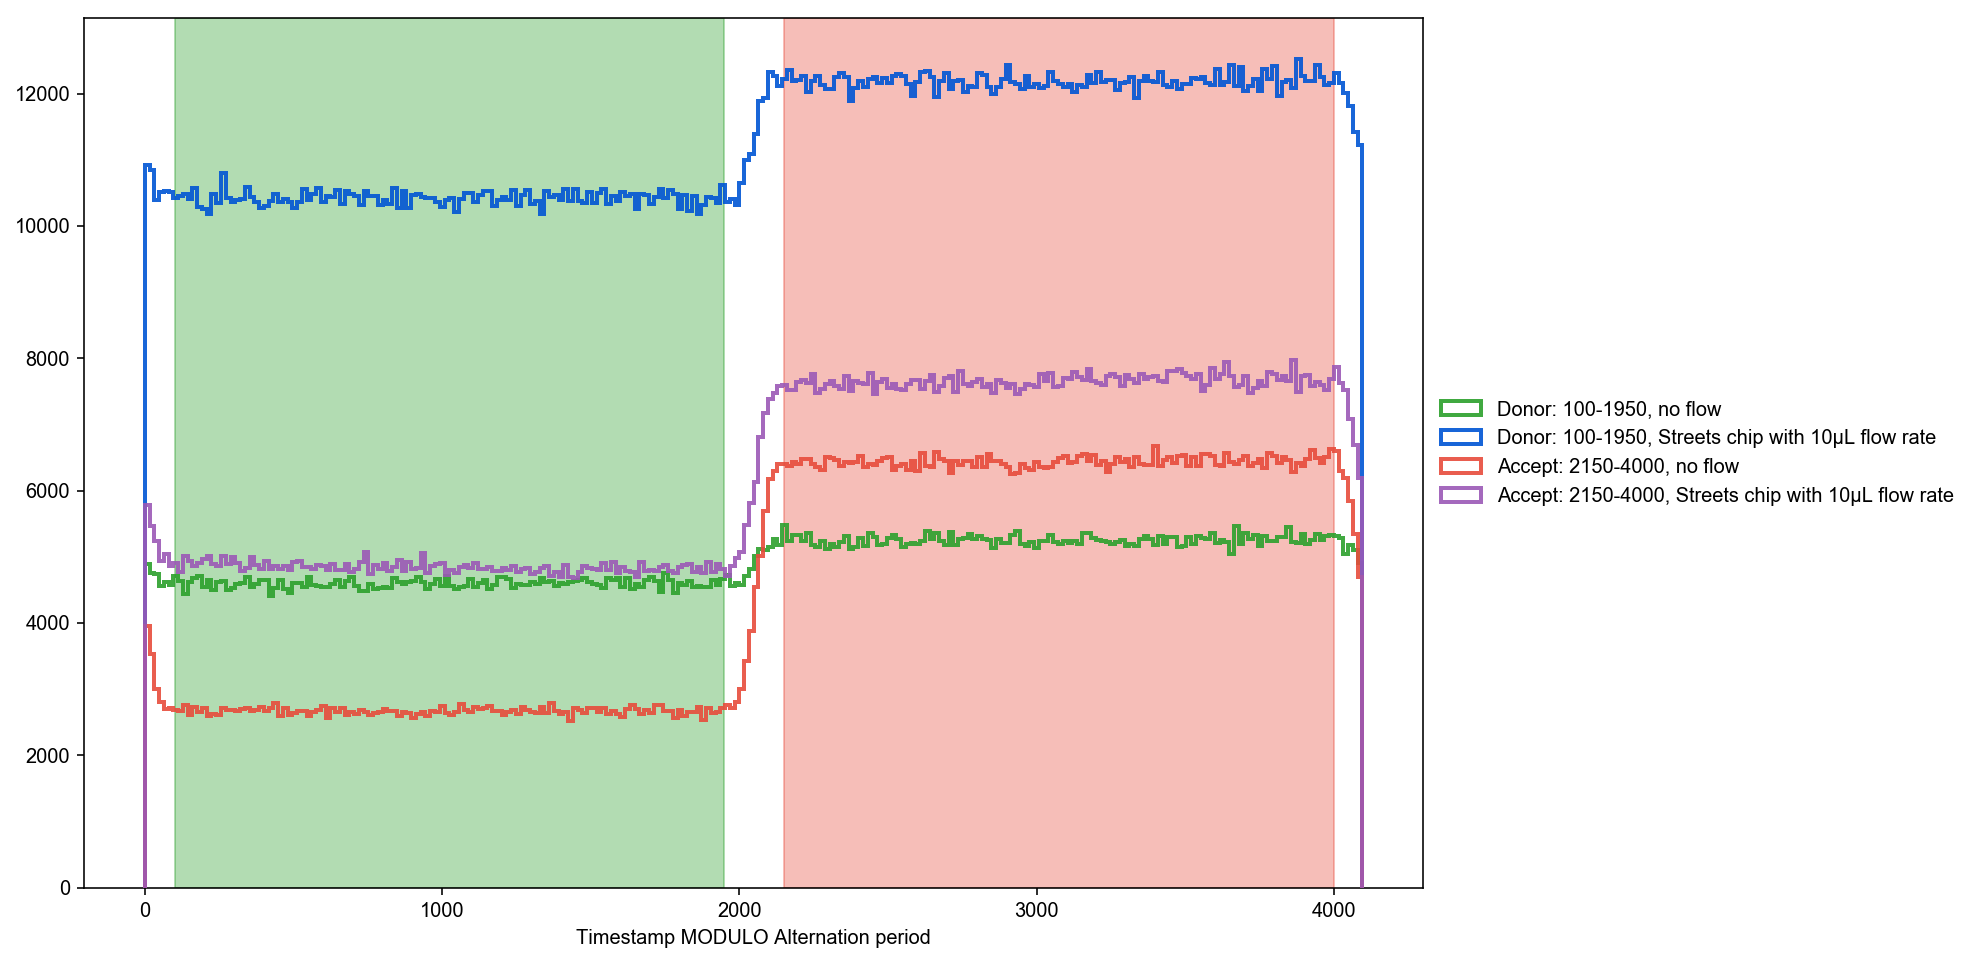

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_alternation_hist_usalex(d0, d1, ax=ax, bins=np.arange(0, 4097, 16));

In [16]:
%%timeit -n1 -r1 
loader.alex_apply_period(d0) 
loader.alex_apply_period(d1)

# Total photons (after ALEX selection):   121,766,143
#  D  photons in D+A excitation periods:   61,895,751
#  A  photons in D+A excitation periods:   59,870,392
# D+A photons in  D  excitation period:    48,825,342
# D+A photons in  A  excitation period:    72,940,801

# Total photons (after ALEX selection):   314,610,922
#  D  photons in D+A excitation periods:  162,968,031
#  A  photons in D+A excitation periods:  151,642,891
# D+A photons in  D  excitation period:    91,730,911
# D+A photons in  A  excitation period:   222,880,011

30.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Select first 0 - 200 s

In [17]:
d0.time_max, d1.time_max

(300.05318665, 300.08232792499996)

In [18]:
d0 = d0.slice_ph(time_s1=0, time_s2=200)
d1 = d1.slice_ph(time_s1=0, time_s2=200)

In [19]:
d0.time_max, d1.time_max

(199.99998507499998, 199.99999778749998)

# Timetraces

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

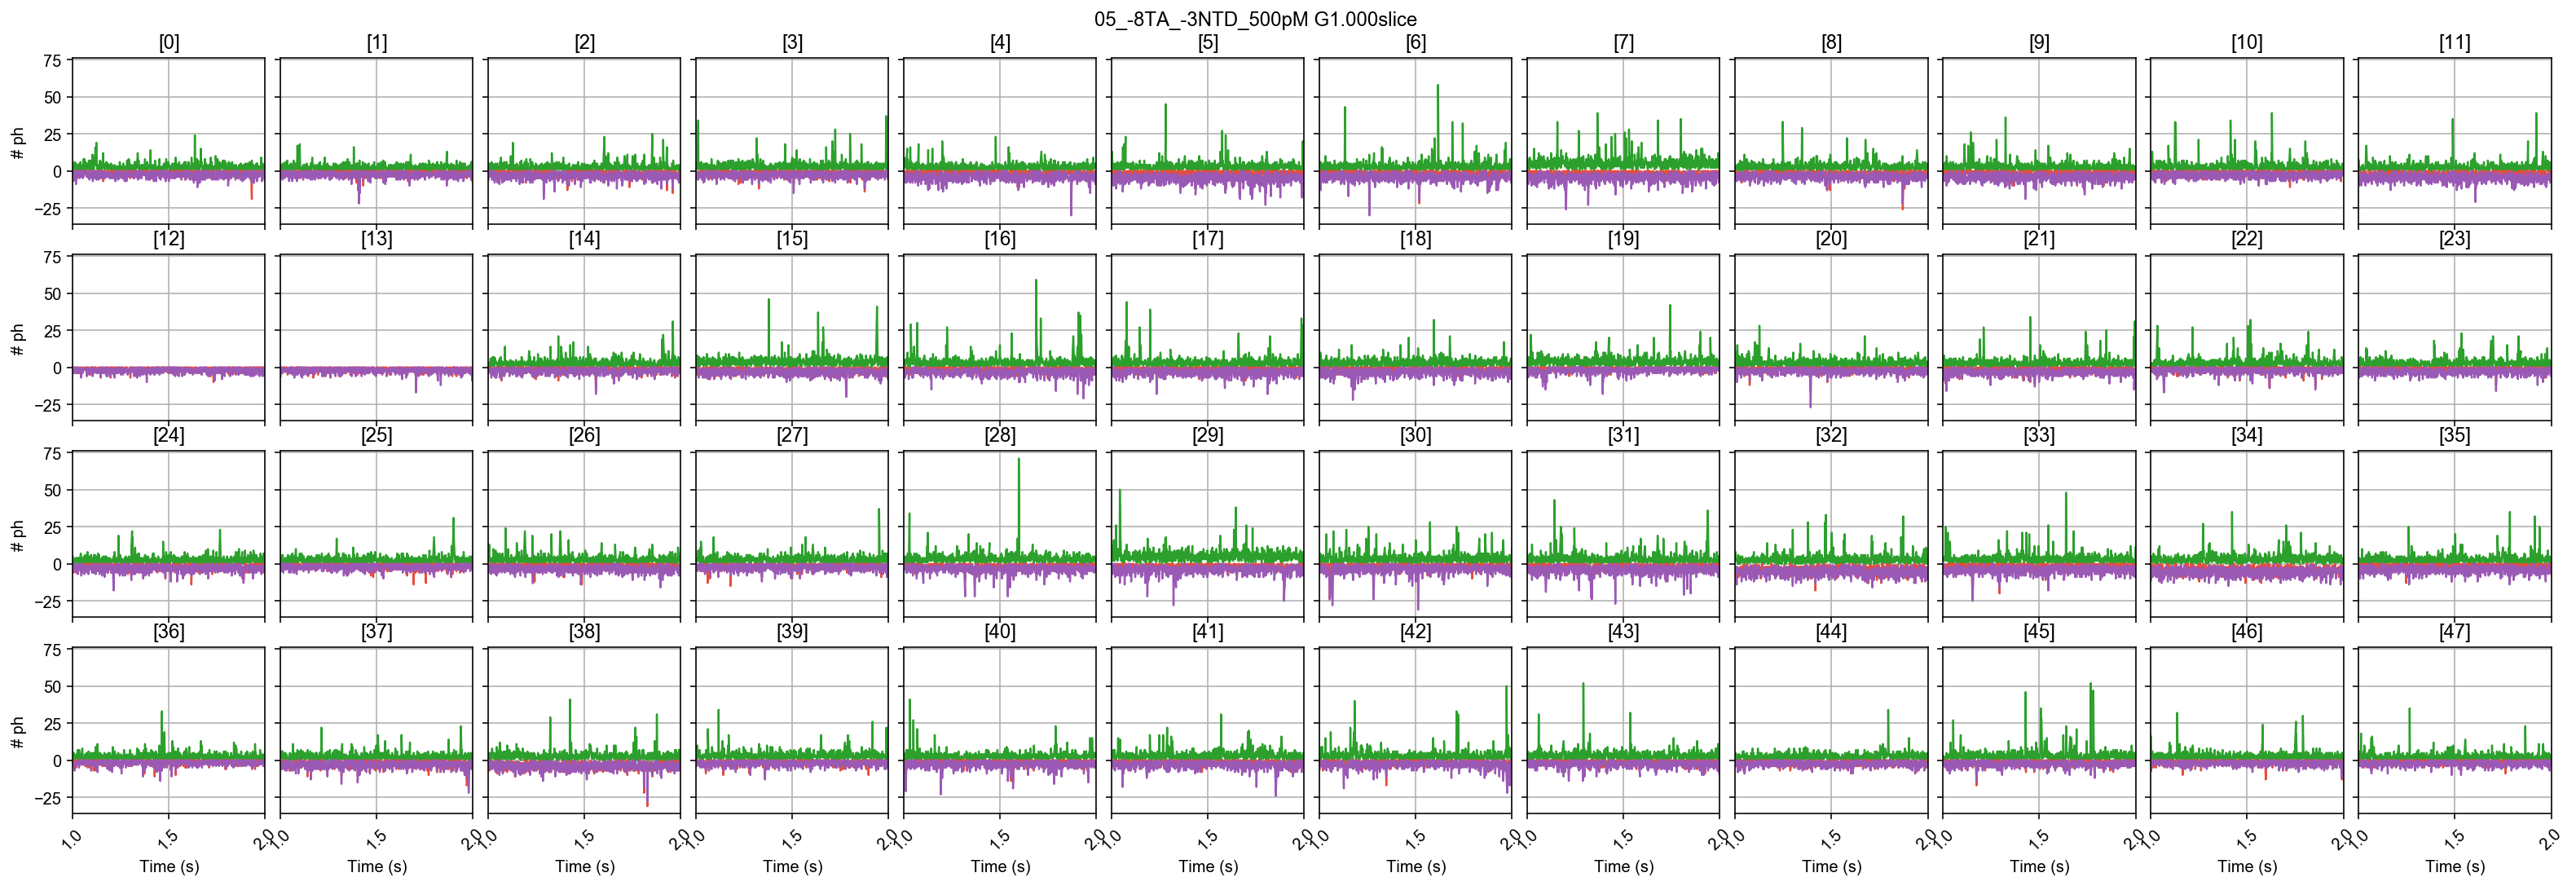

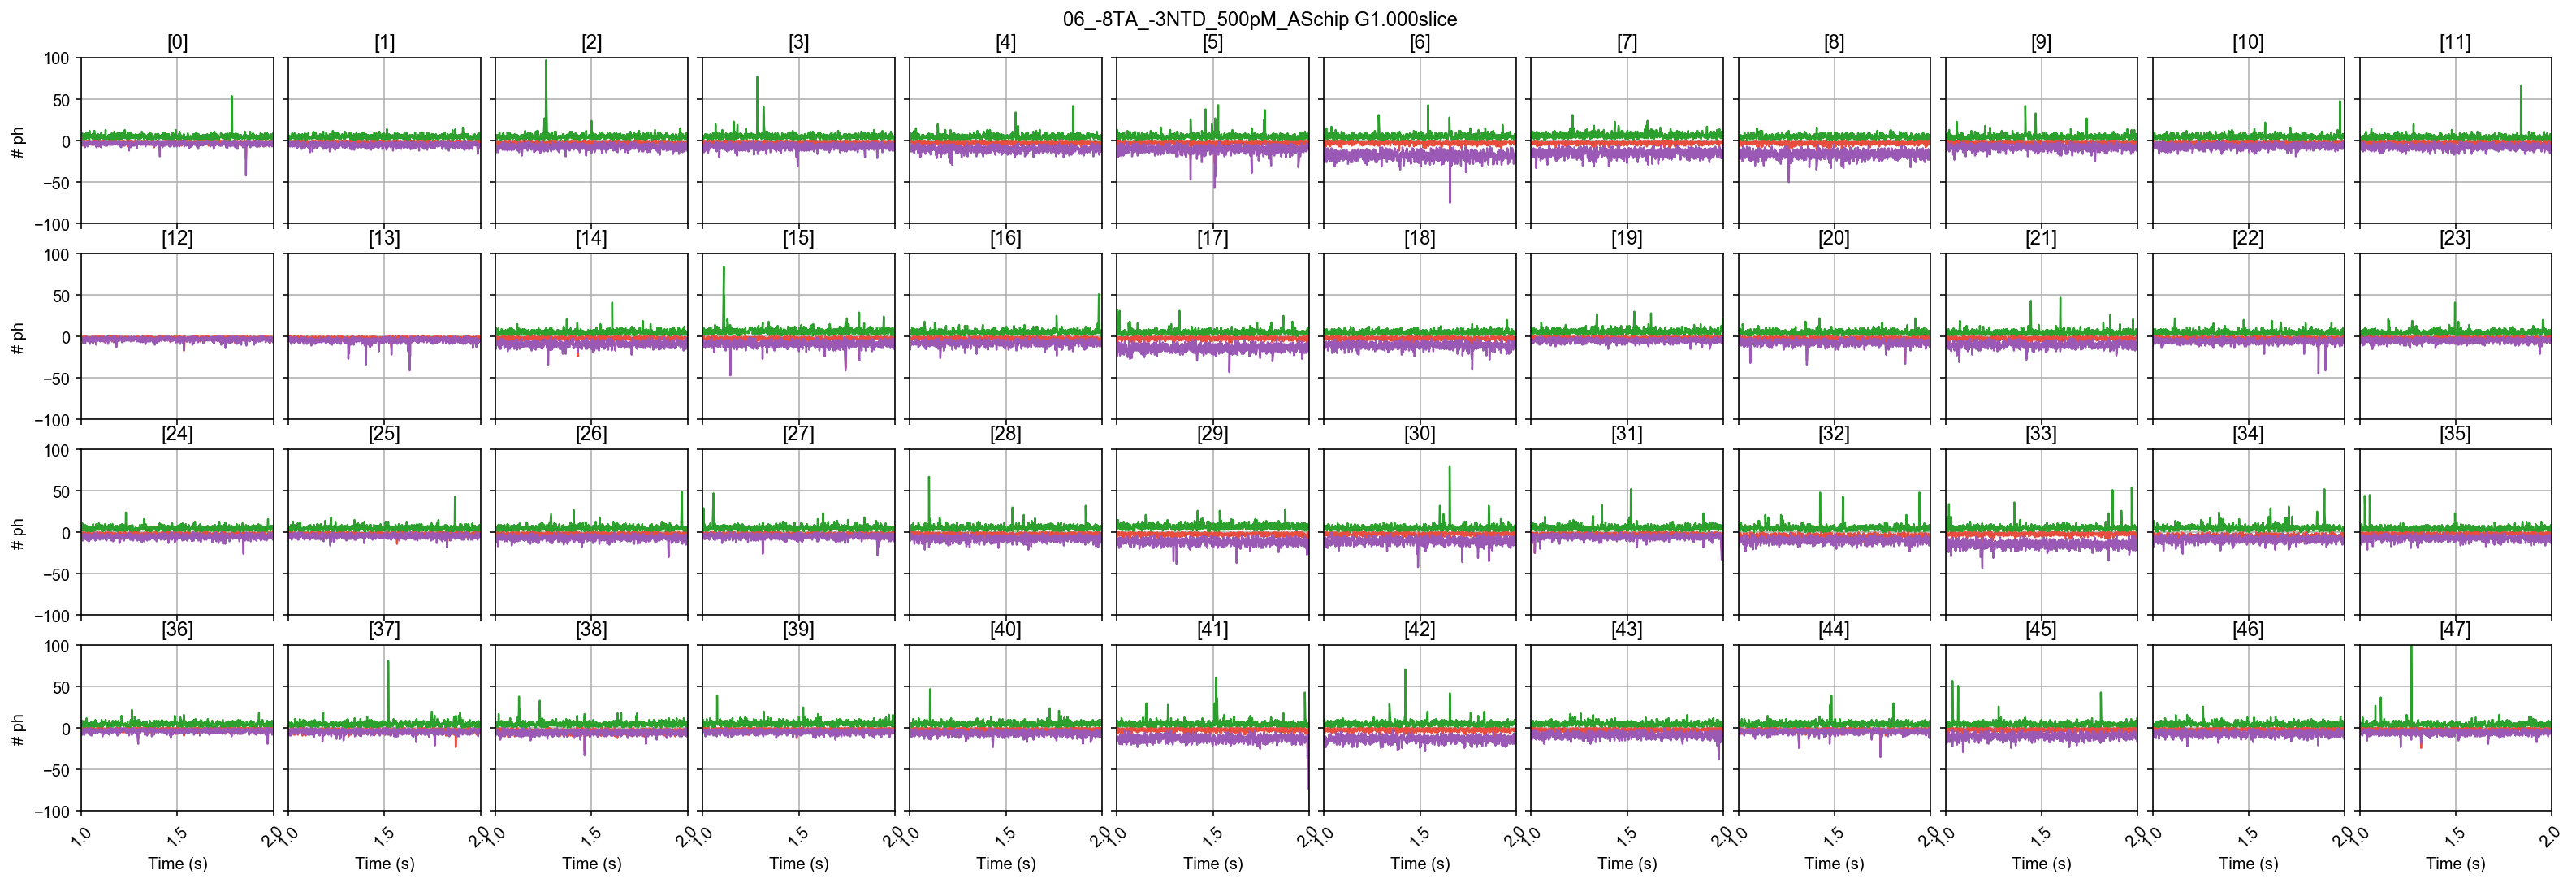

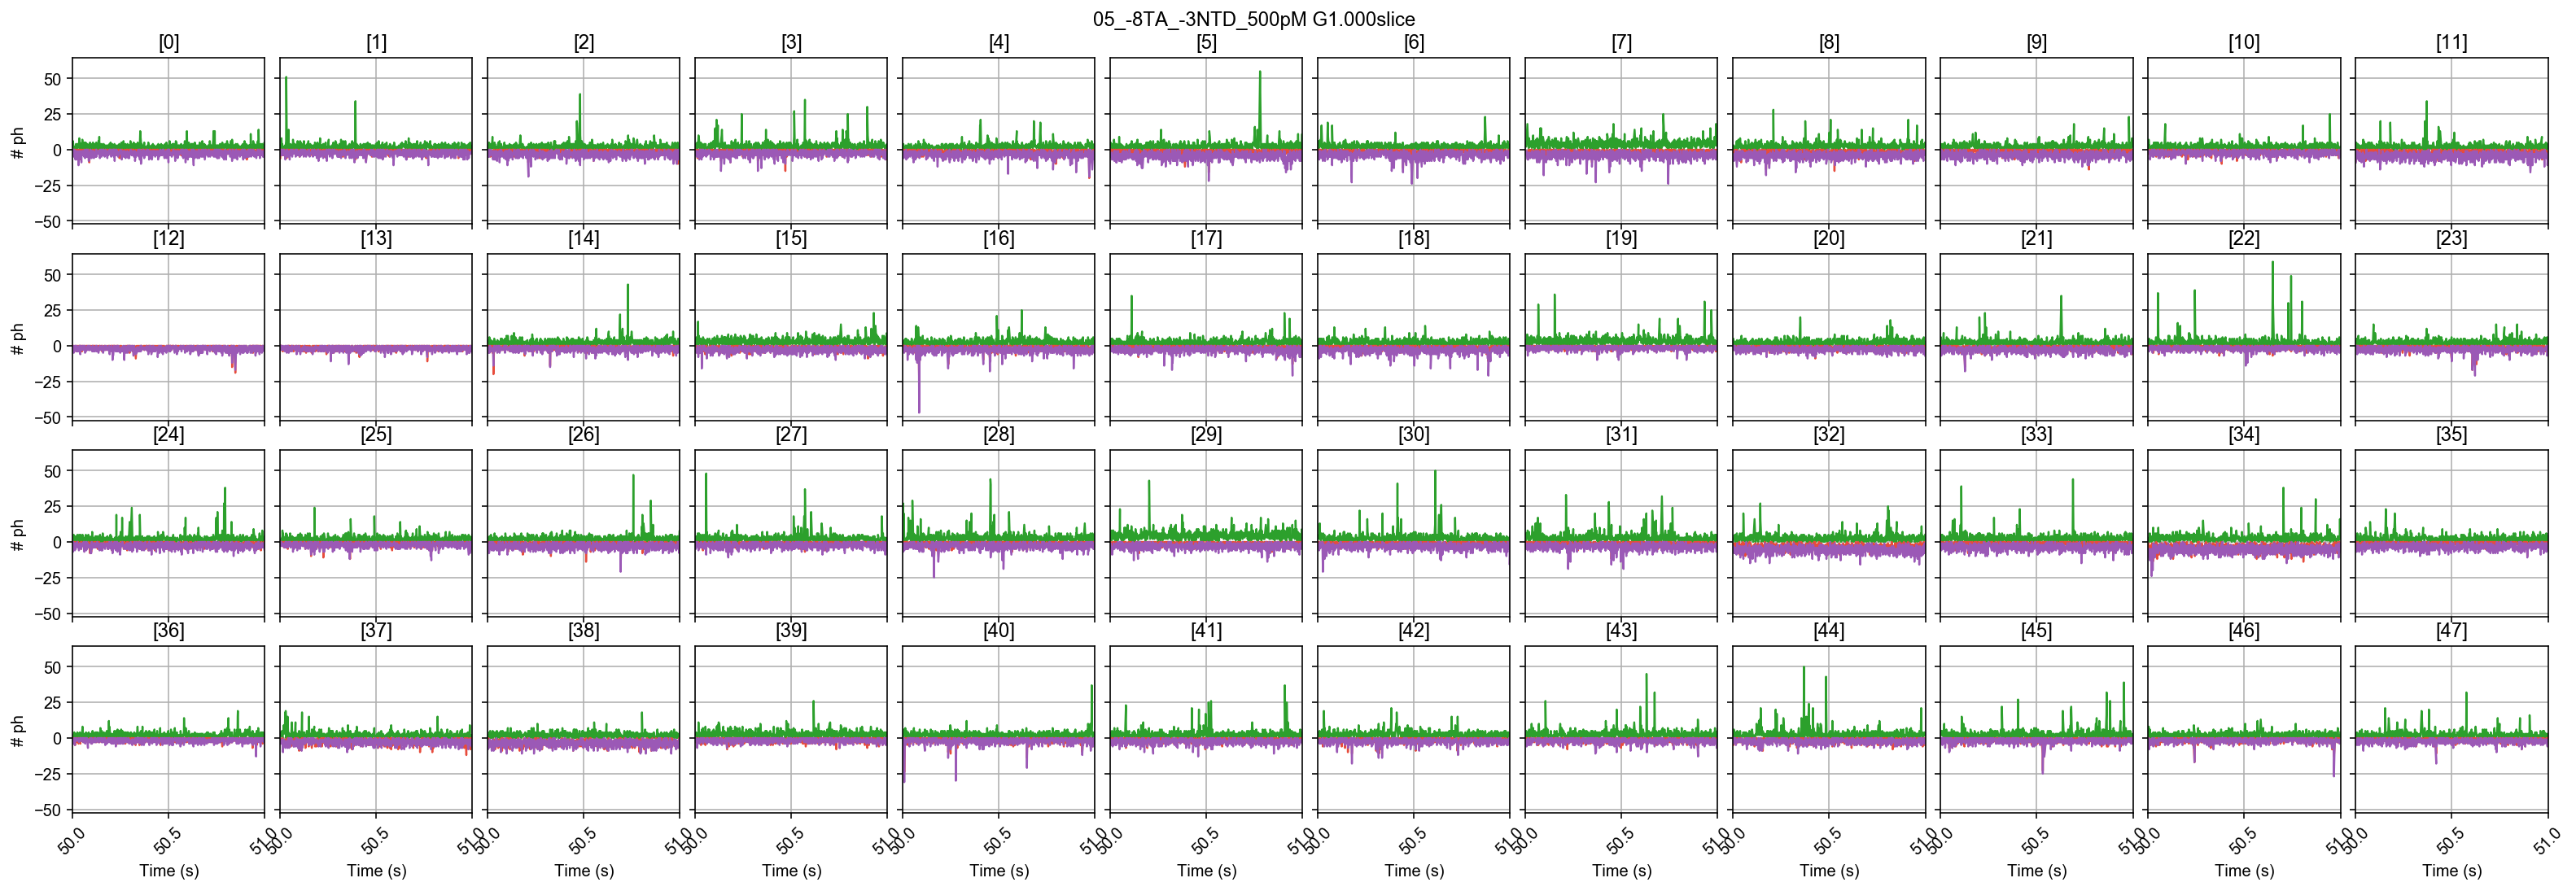

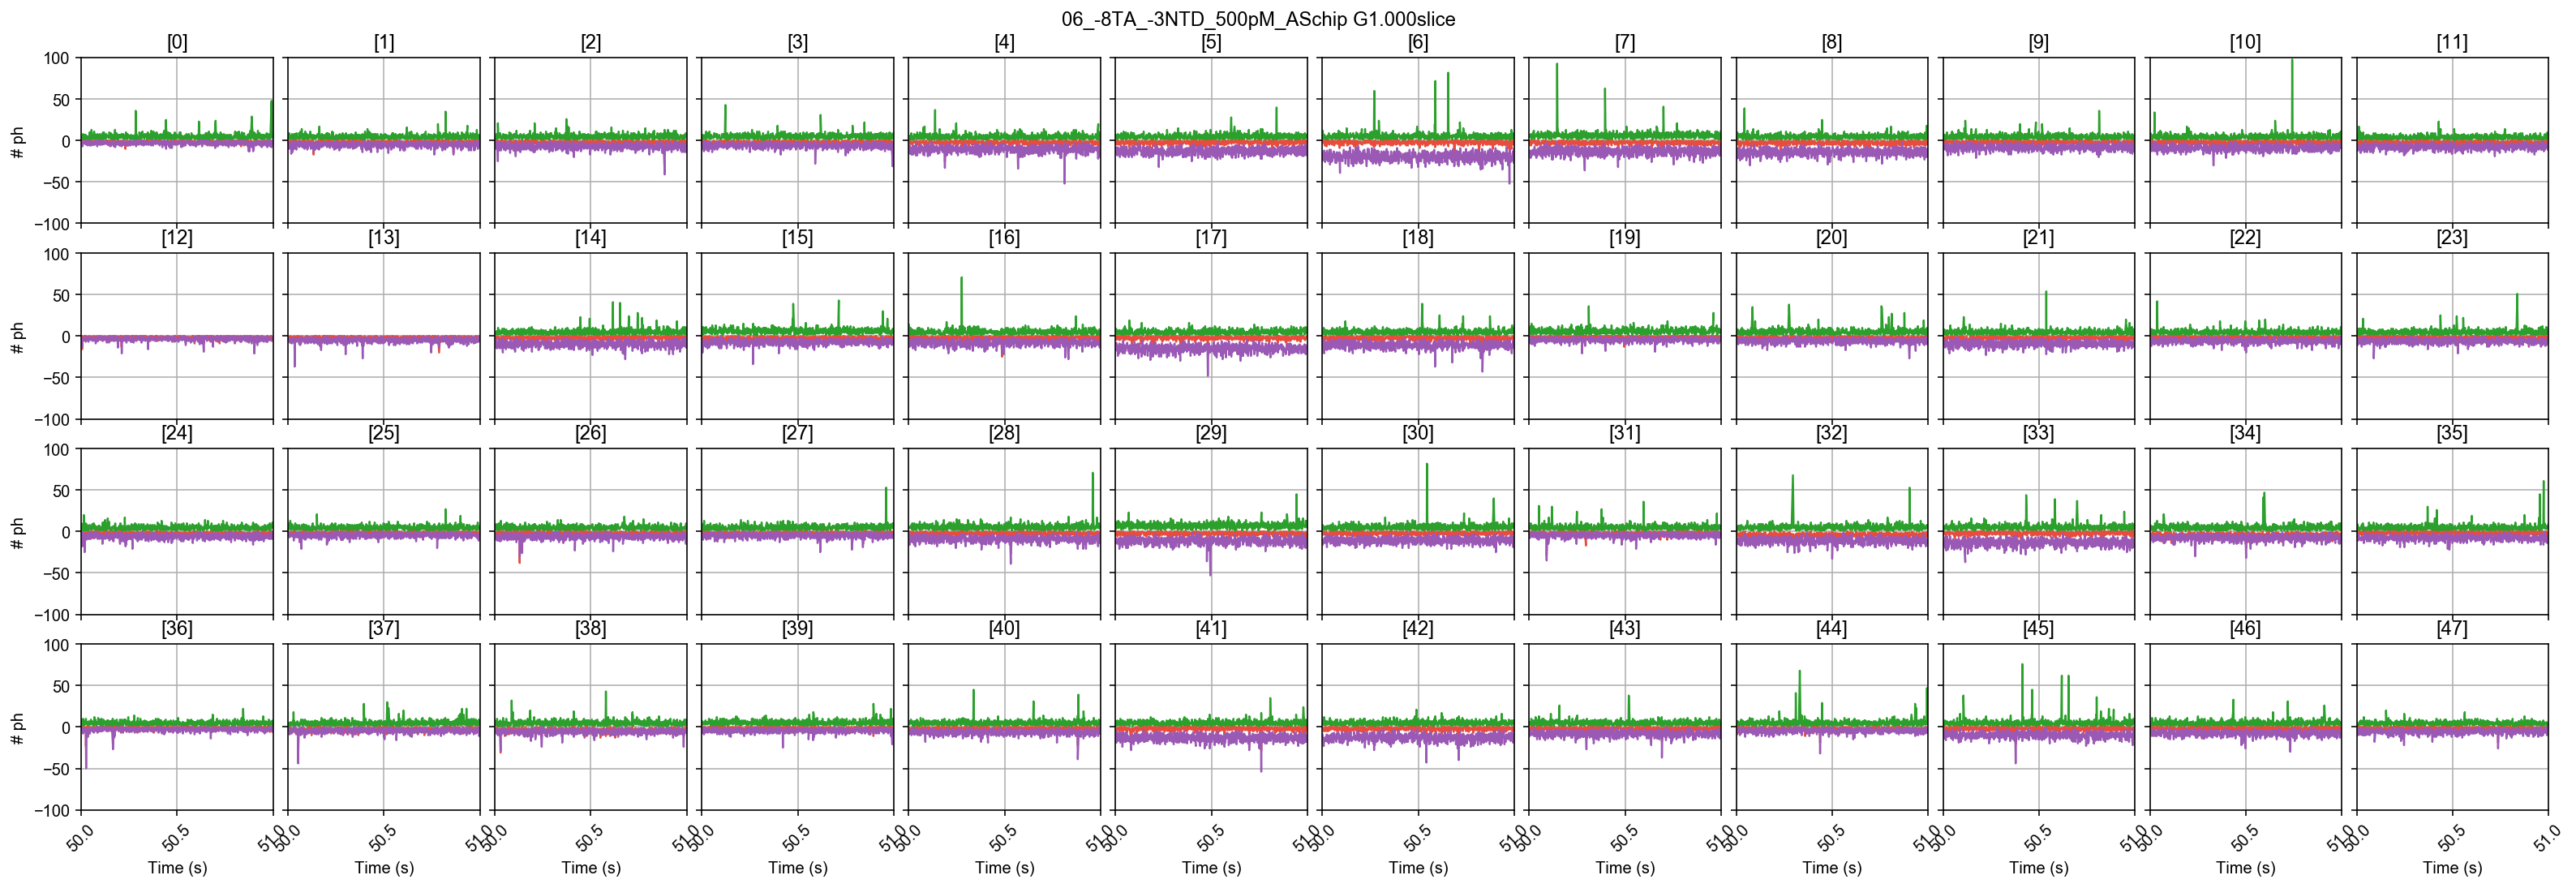

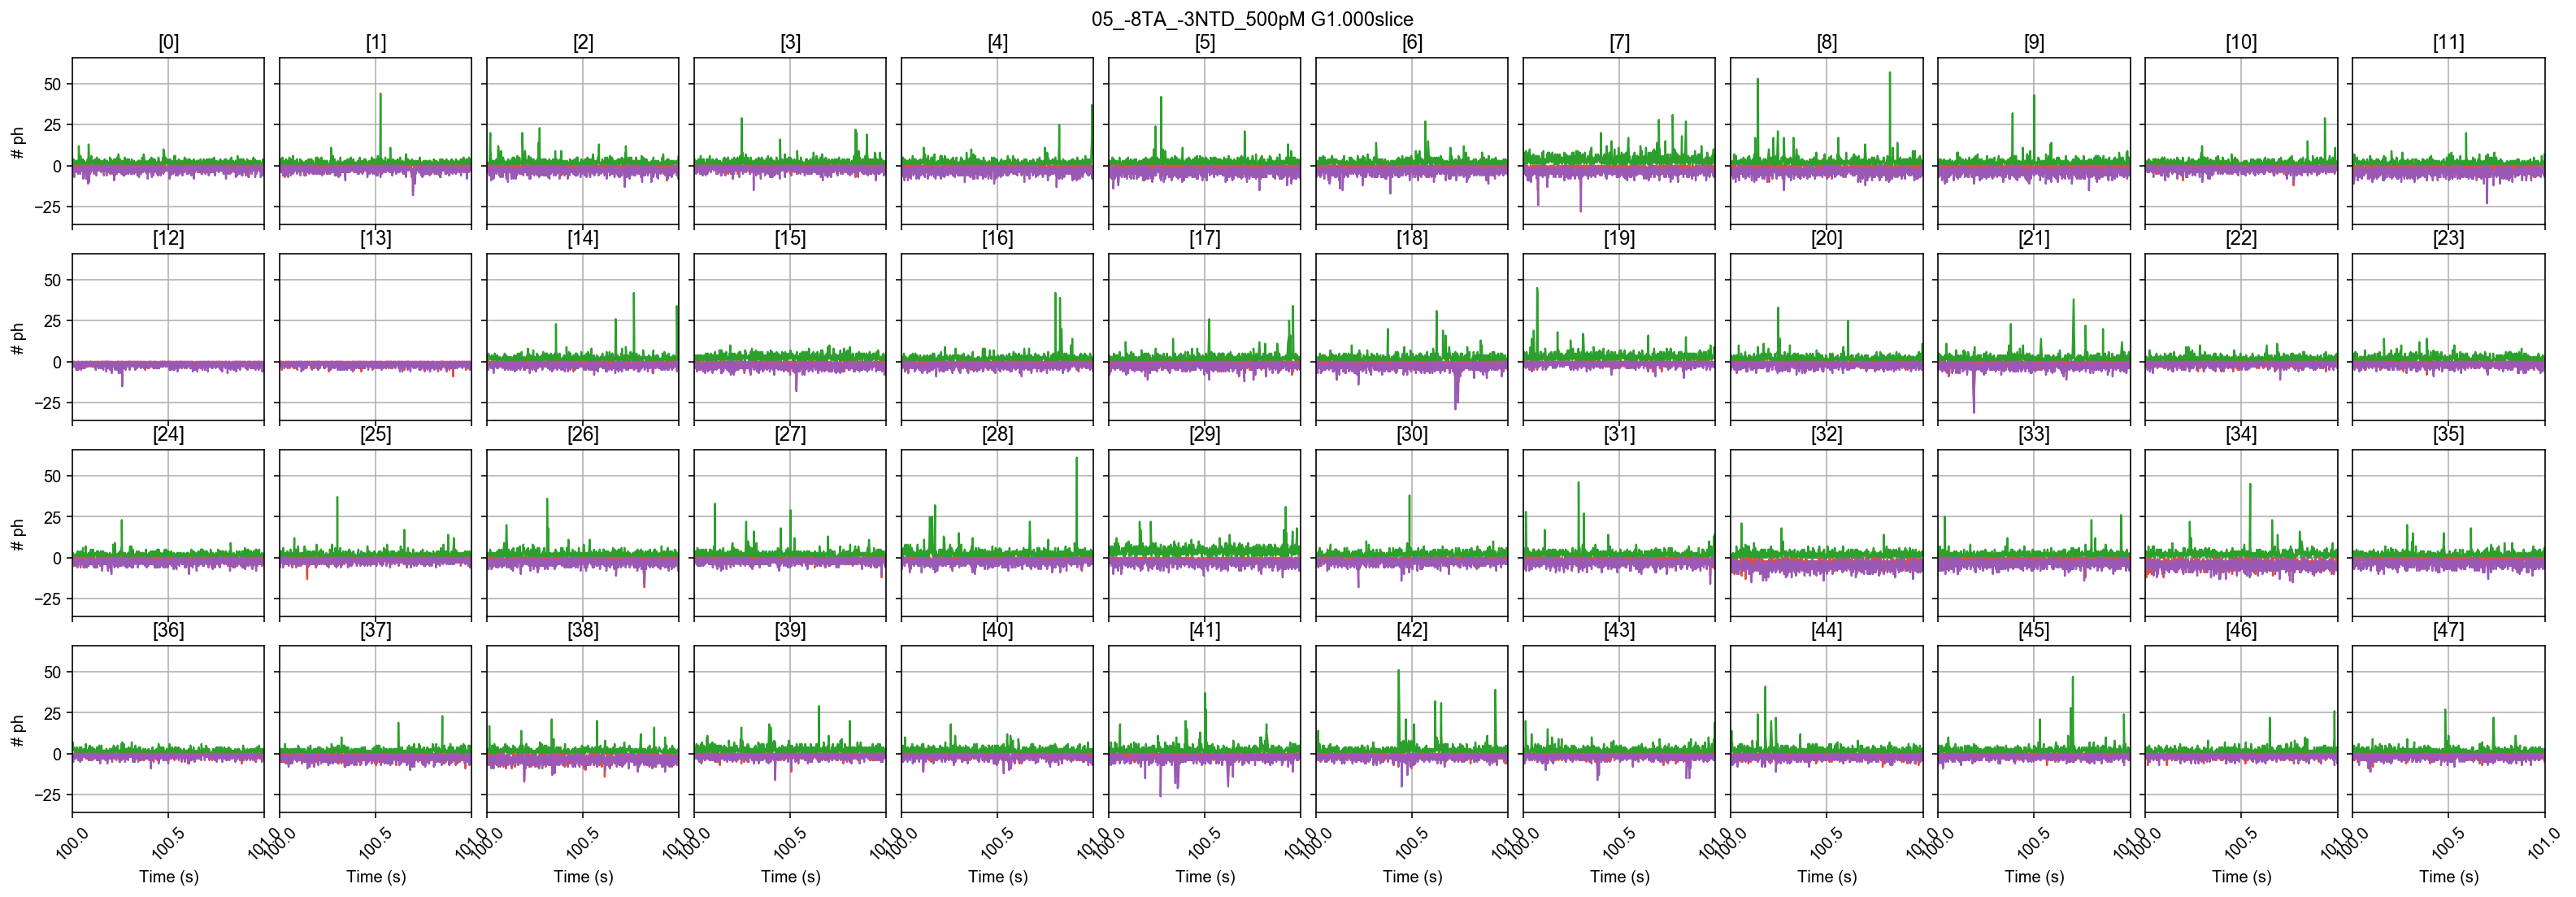

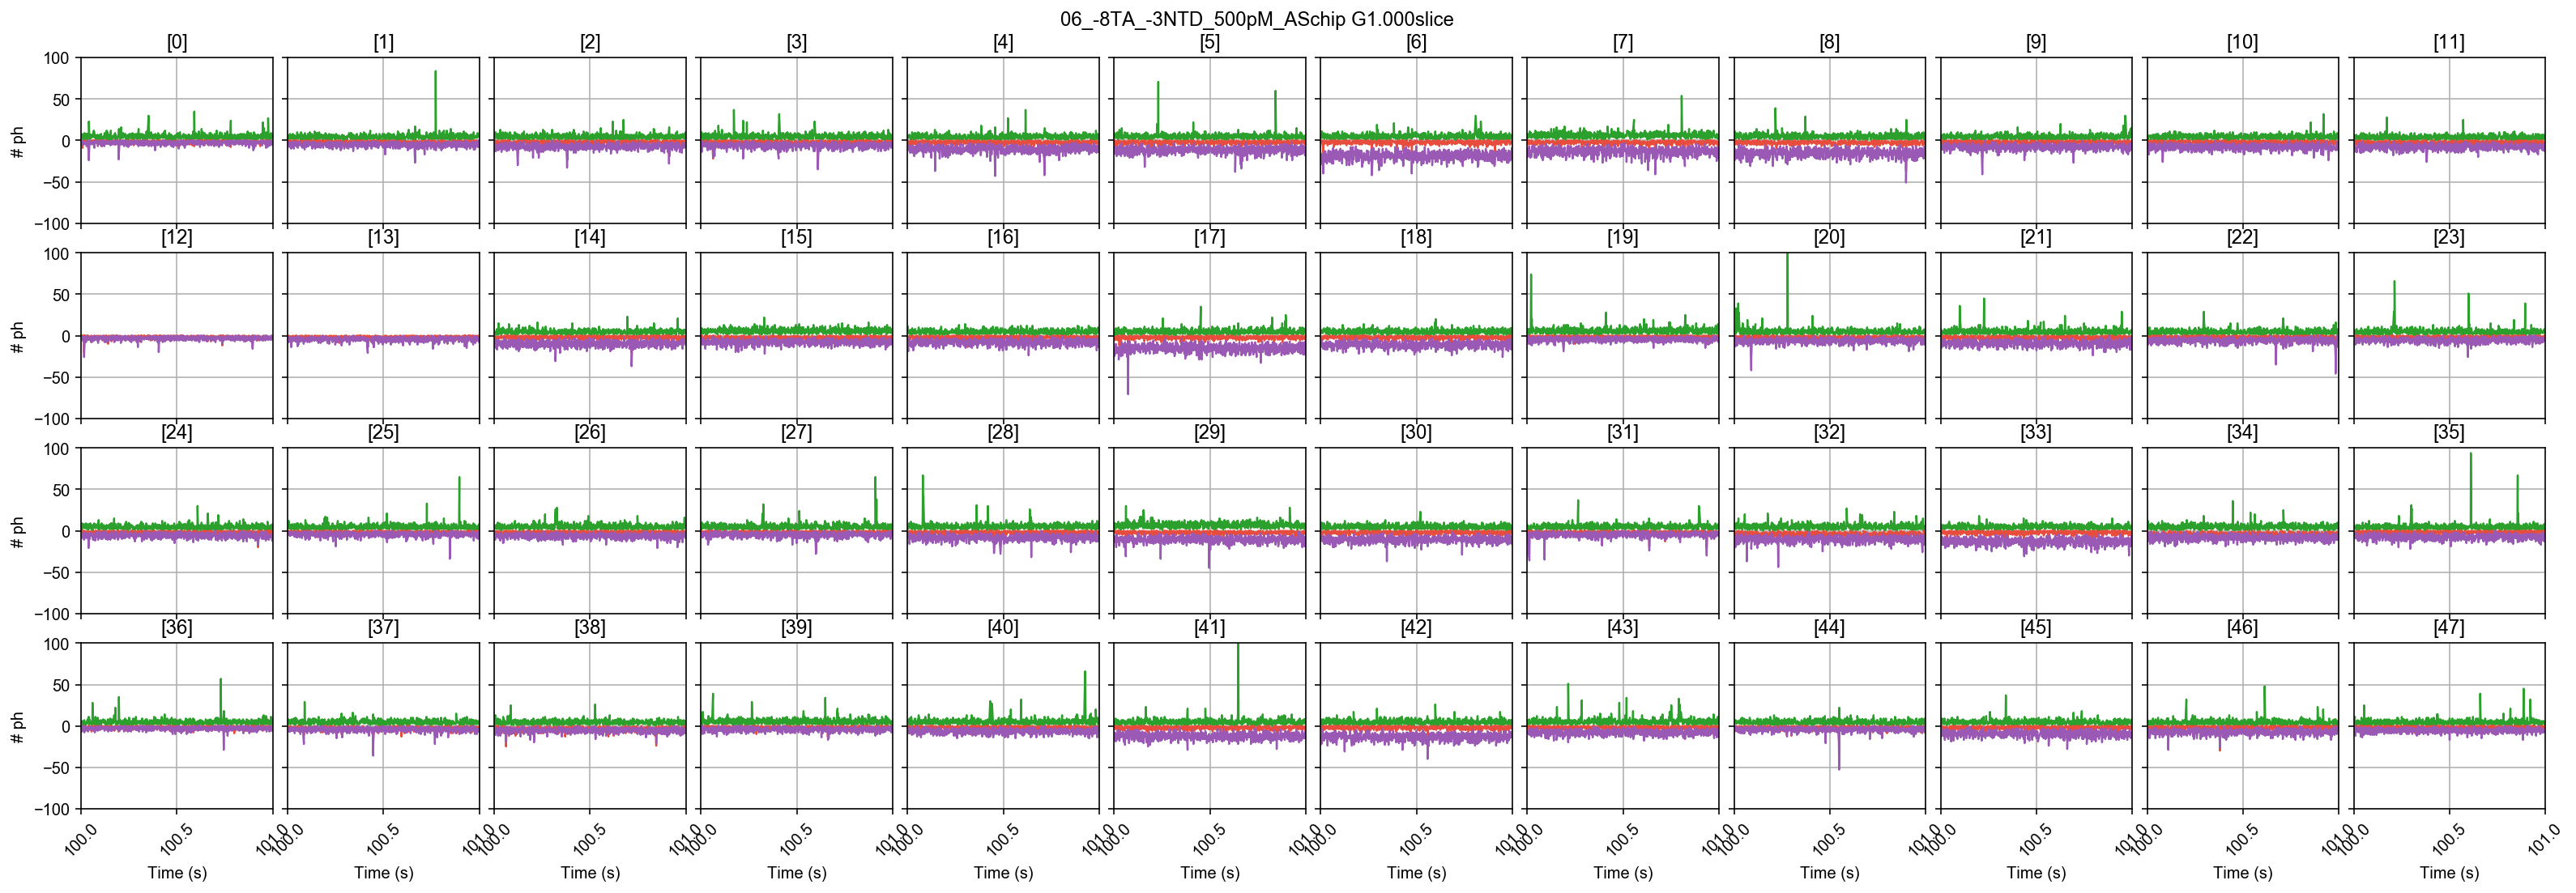

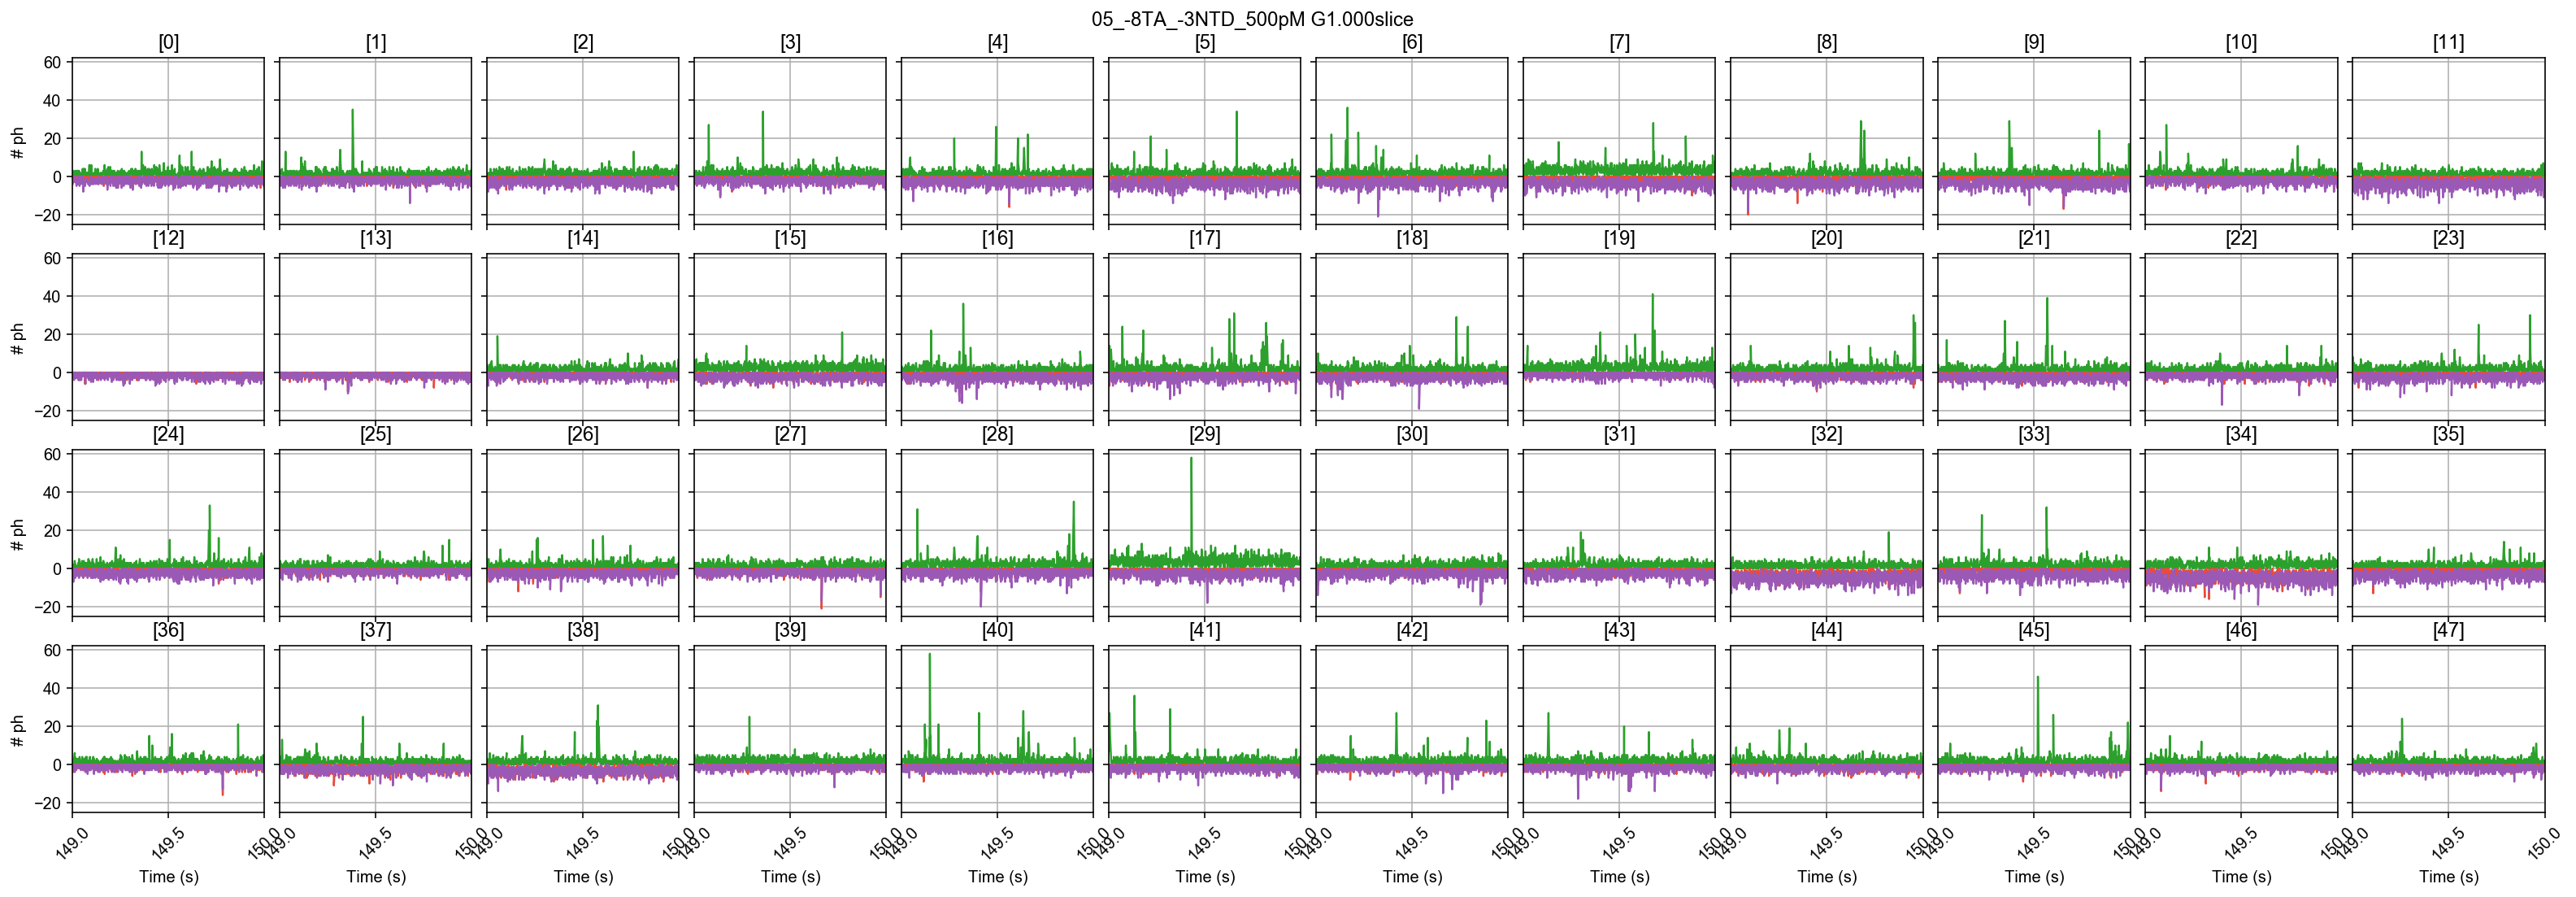

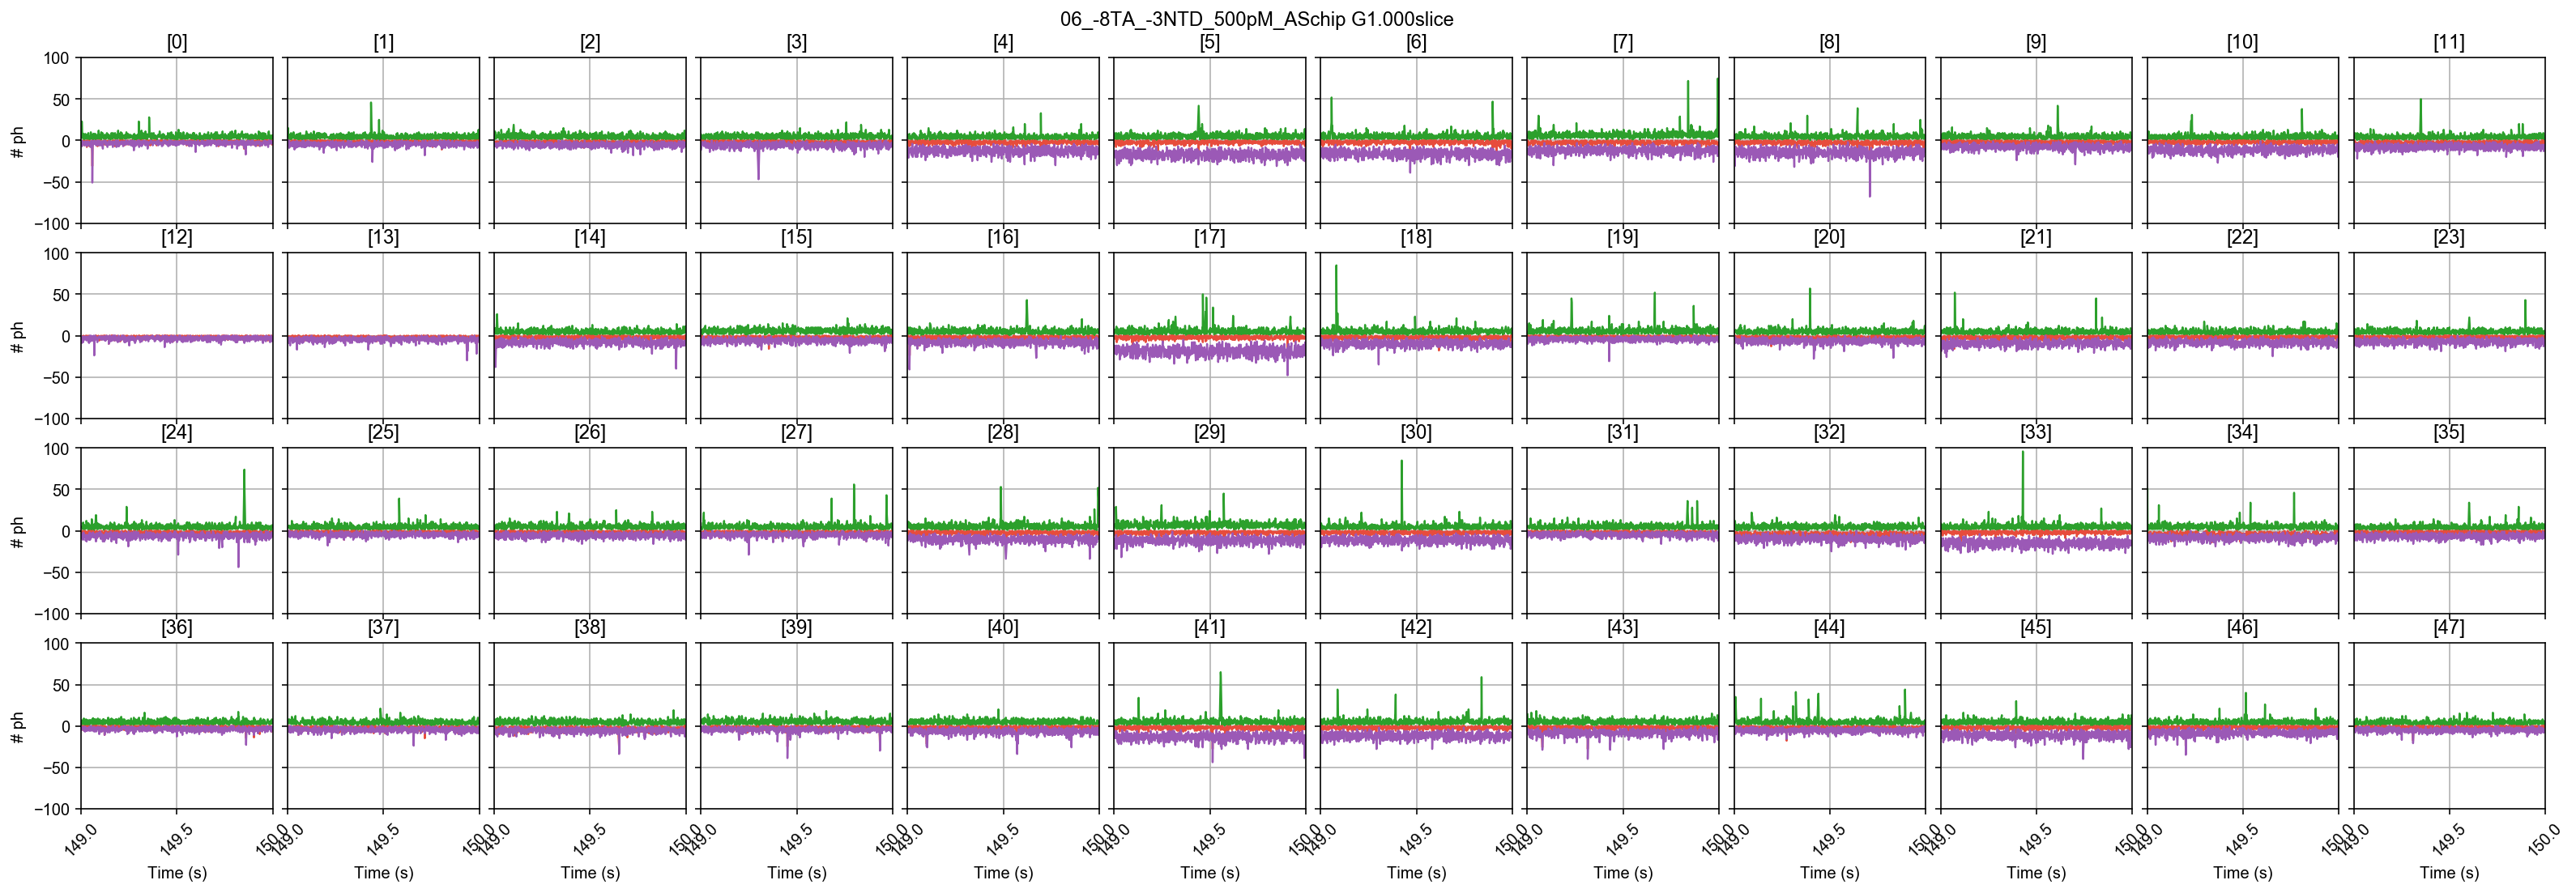

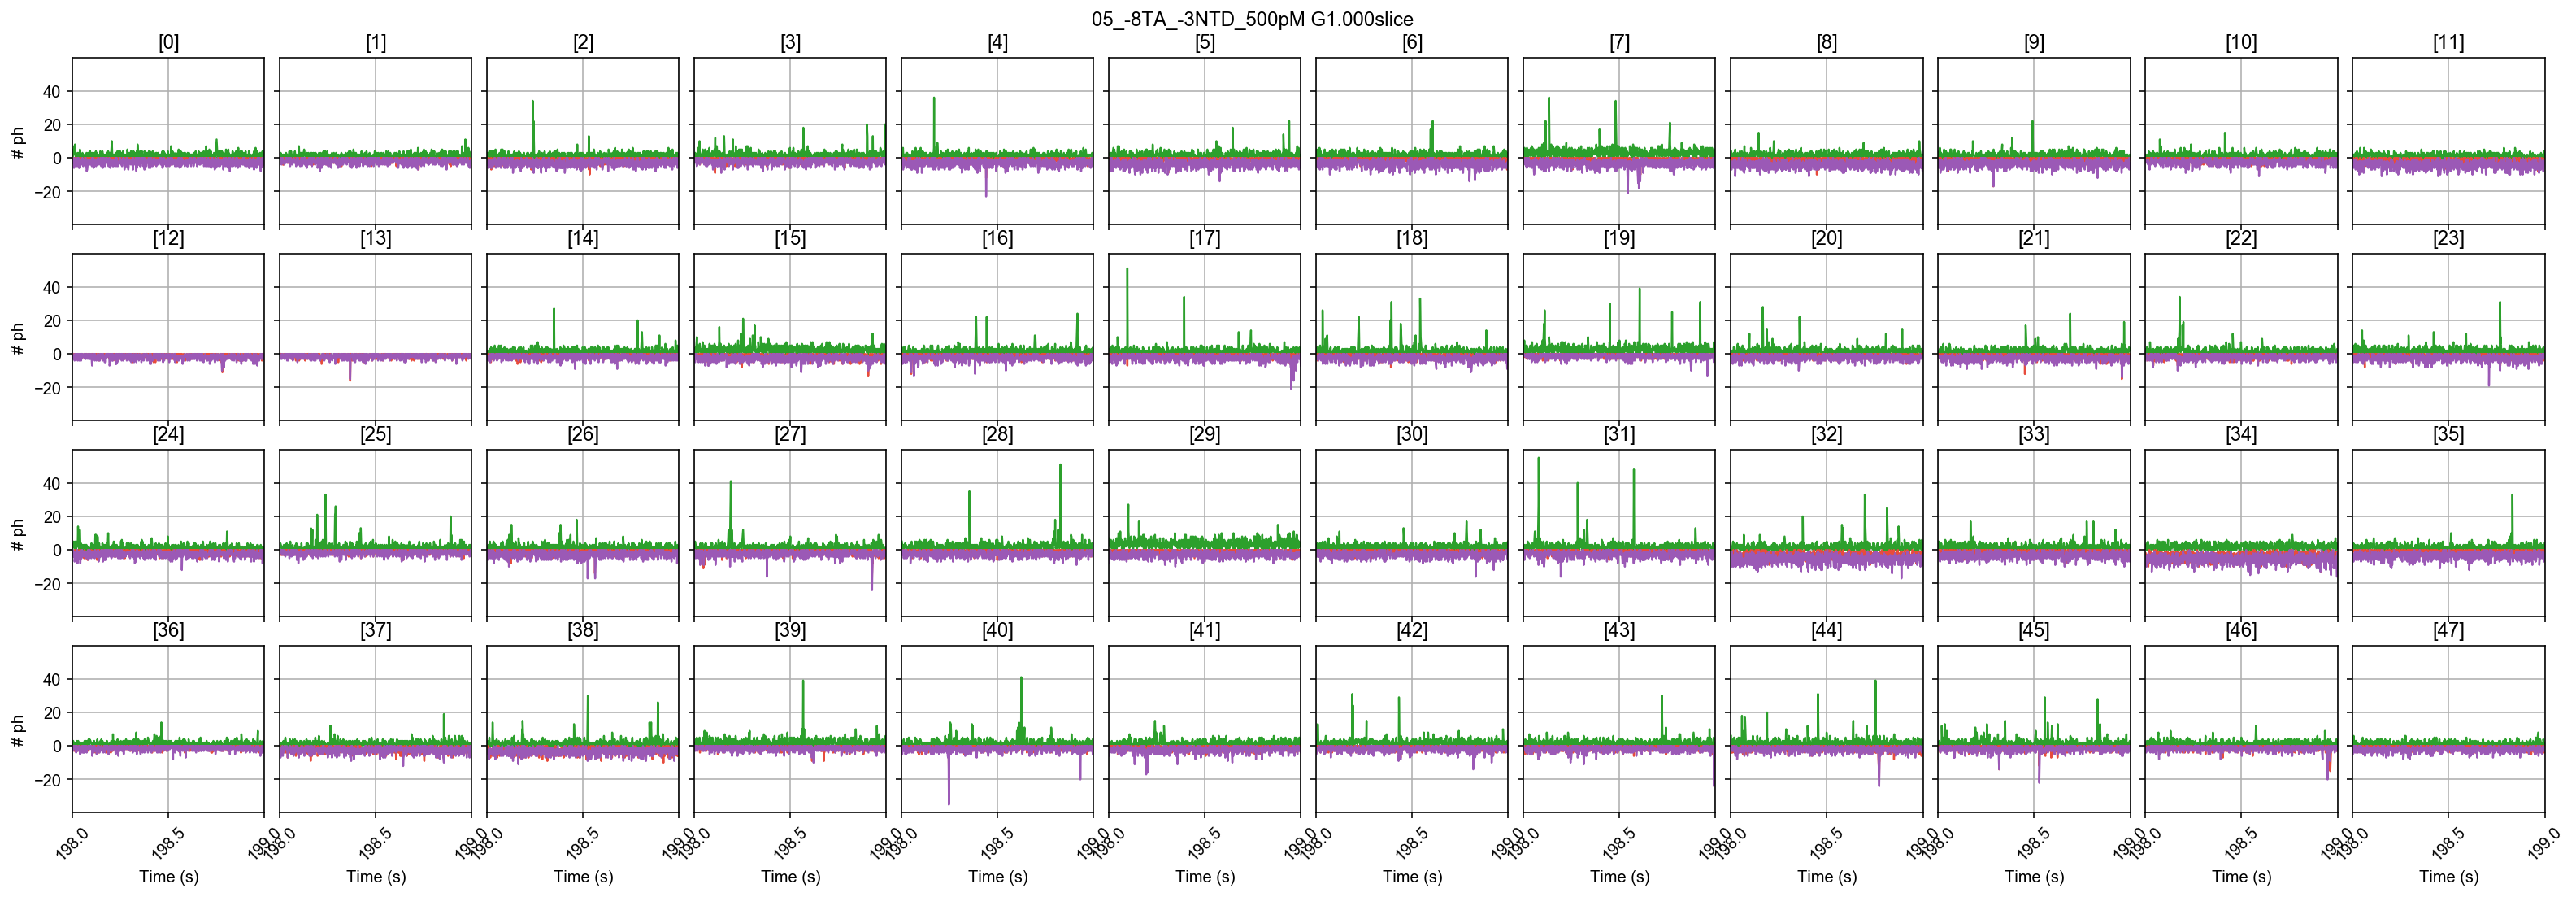

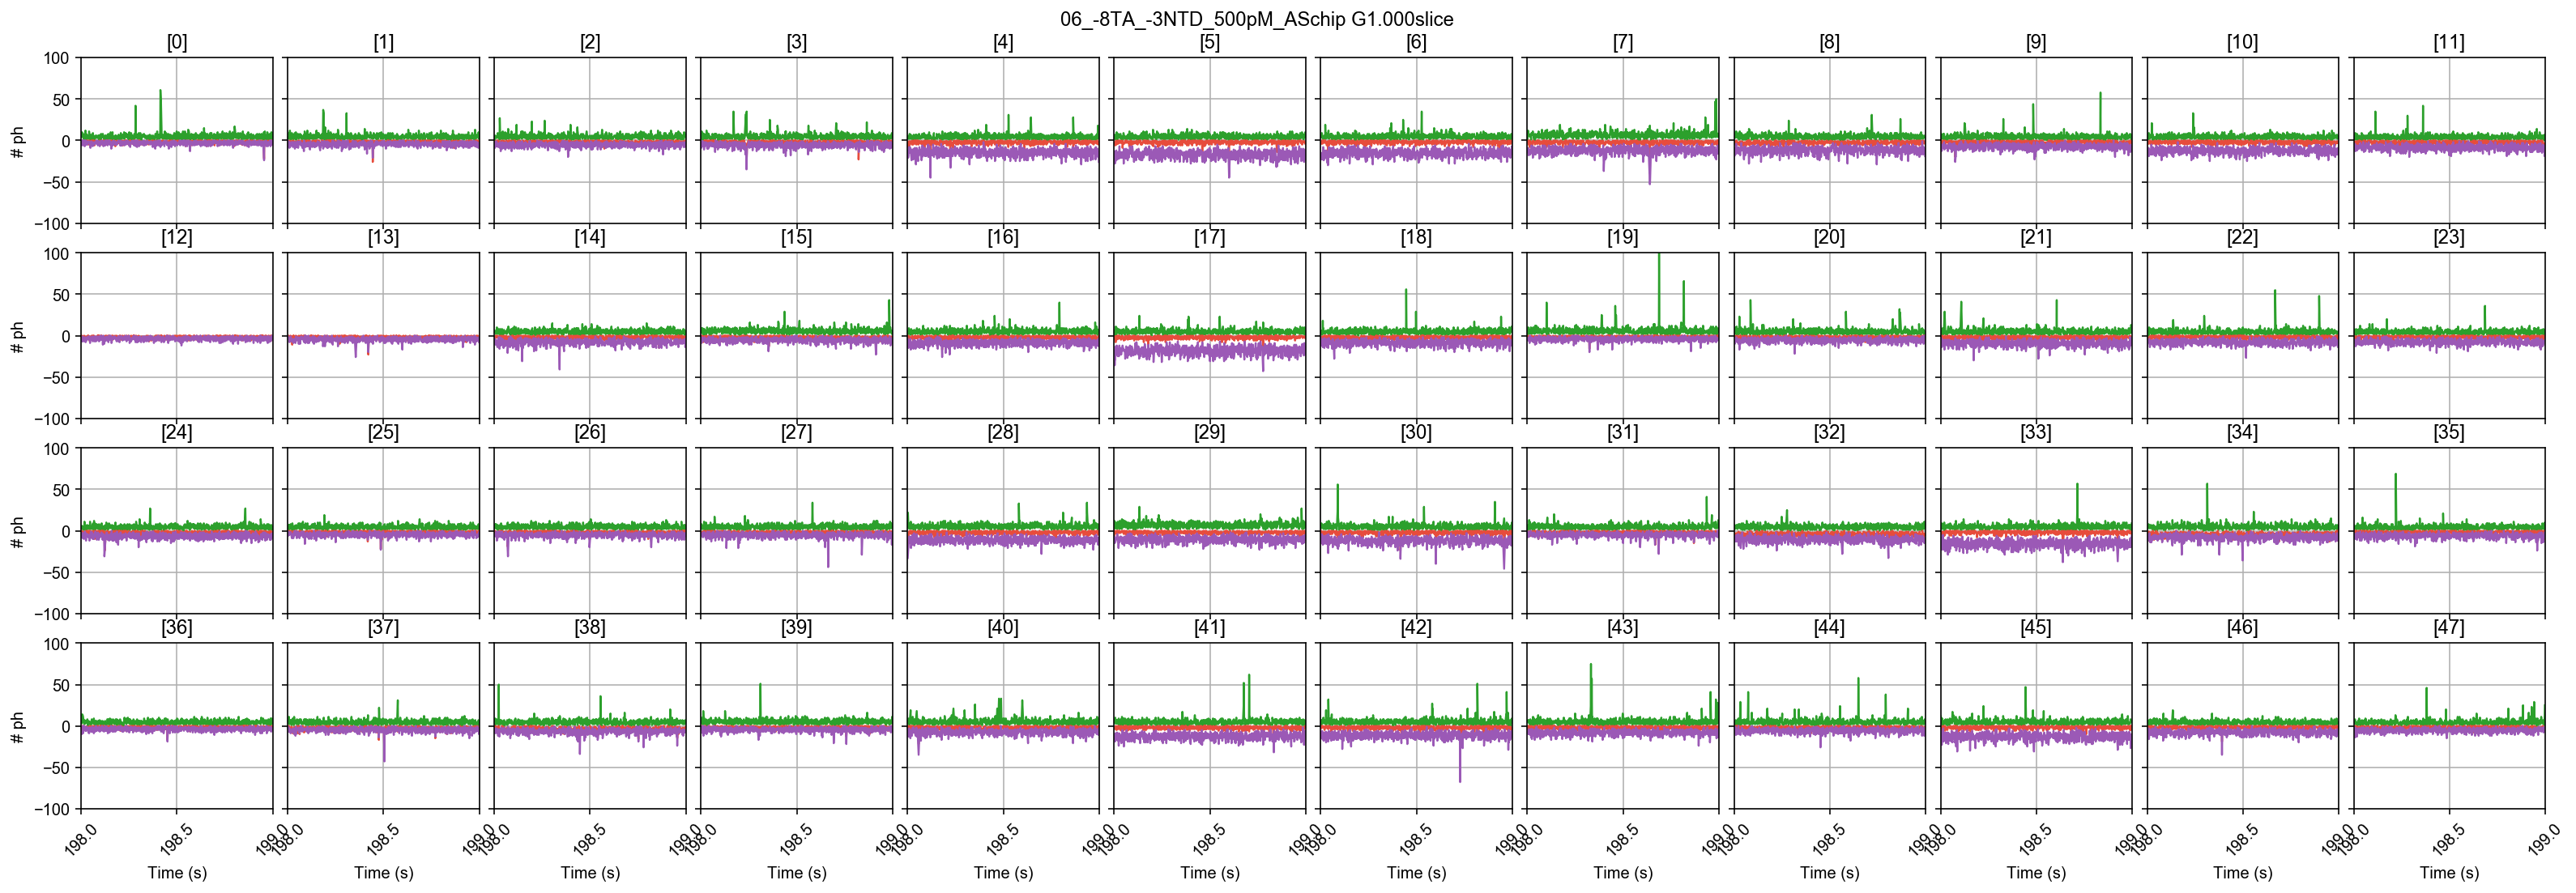

In [20]:
if plot_timetraces:
    num_time_points = 5
    kws = dict(figsize=(24, 8), xrotation=45)
    
    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d0.time_min+1, d0.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d0, timetrace, tmin=i, tmax=i+1, **kws)
        dplot(d1, timetrace, tmin=i, tmax=i+1, **kws);
        plt.ylim(-100, 100)
        #savefig("%s_timetrace_t=%d-%d" % (mlabel[0], i, i+1))

# Background

In [21]:
d0.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)
d1.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


## Plot interphoton delays

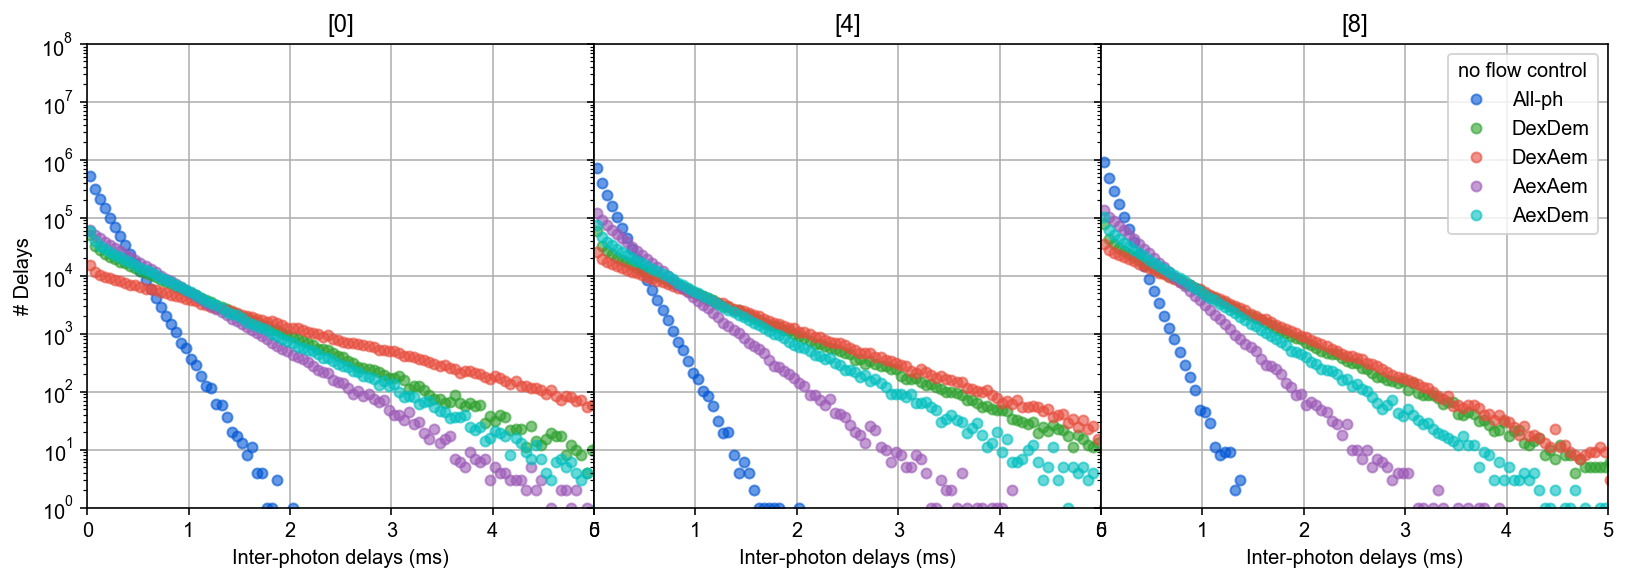

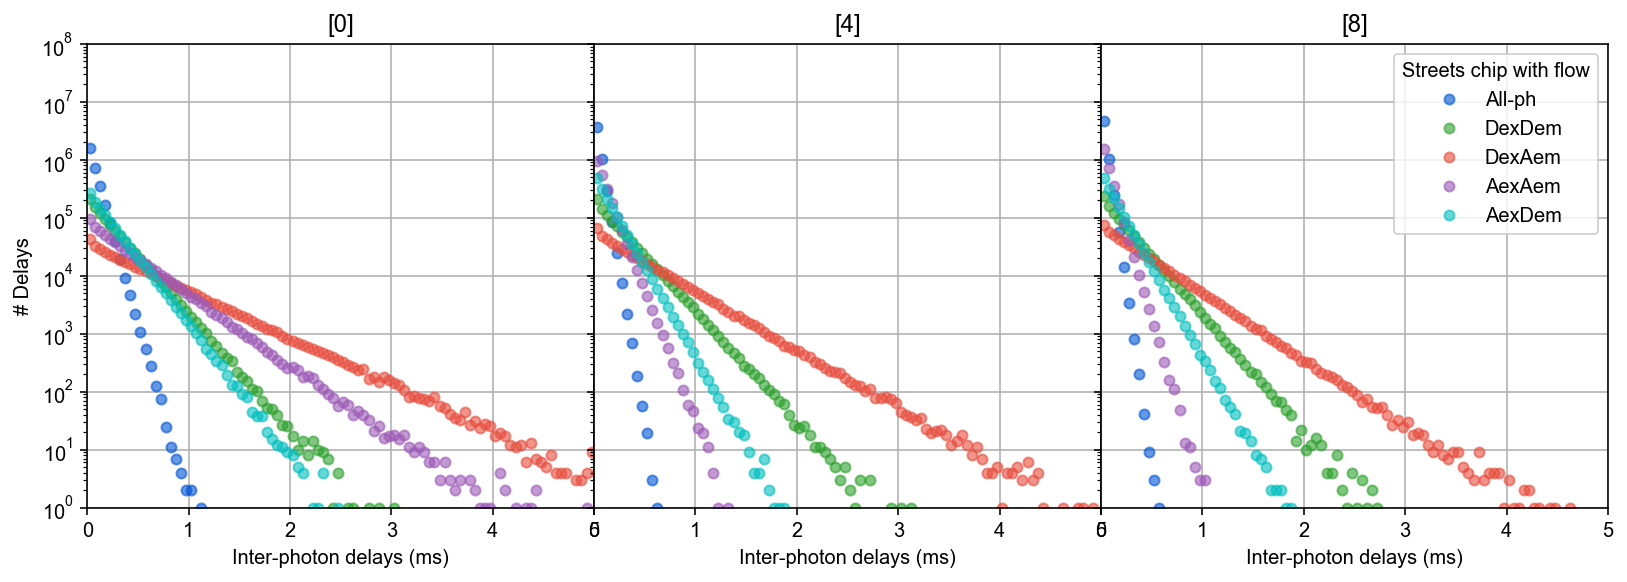

In [22]:
dplot(d0, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='no flow control')

dplot(d1, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='Streets chip with flow');

In [23]:
def _normalize_kwargs(kwargs, kind='patch'):
    """Convert matplotlib keywords from short to long form."""
    if kwargs is None:
        return {}

    if kind == 'line2d':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          mec='markeredgecolor', mew='markeredgewidth',
                          mfc='markerfacecolor', ms='markersize',)
    elif kind == 'patch':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          ec='edgecolor', fc='facecolor',)
    for short_name in long_names:
        if short_name in kwargs:
            kwargs[long_names[short_name]] = kwargs.pop(short_name)
    return kwargs

In [24]:
_ph_sel_color_dict = {Ph_sel('all'): blue, 
                      Ph_sel(Dex='Dem'): green,
                      Ph_sel(Dex='Aem'): red, 
                      Ph_sel(Aex='Aem'): purple,
                      Ph_sel(Aex='Dem'): 'c', }
_ph_sel_label_dict = {Ph_sel('all'): 'All-ph', 
                      Ph_sel(Dex='Dem'): 'DexDem',
                      Ph_sel(Dex='Aem'): 'DexAem', 
                      Ph_sel(Aex='Aem'): 'AexAem',
                      Ph_sel(Aex='Dem'): 'AexDem'}

In [25]:
def hist_interphoton_single(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None,
                            ph_sel=Ph_sel('all'), period=None,
                            yscale='log', xscale='linear', xunit='ms',
                            plot_style=None):
    
    unit_dict = {'s': 1, 'ms': 1e3, 'us': 1e6, 'ns': 1e9}
    assert xunit in unit_dict
    scalex = unit_dict[xunit]

    # Compute interphoton delays
    if period is None:
        ph0_times = d0.get_ph_times(ich=i, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times(ich=i, ph_sel=ph_sel)
    else:
        ph0_times = d0.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
    delta_ph0_t = np.diff(ph0_times) * d0.clk_p
    delta_ph1_t = np.diff(ph1_times) * d1.clk_p
    if tmax is None:
        tmax0 = delta_ph0_t.max()
        tmax1 = delta_ph1_t.max()
        
    # Compute bin edges if not passed in
    if bins is None:
        # Shift by half clk_p to avoid "beatings" in the distribution
        # due to floating point inaccuracies.
        bins0 = np.arange(0, tmax0 + binwidth, binwidth) - 0.5 * d0.clk_p
        bins1 = np.arange(0, tmax1 + binwidth, binwidth) - 0.5 * d1.clk_p
    else:
        warnings.warn('Using `bins` and ignoring `tmax` and `binwidth`.')
    t0_ax = bins0[:-1] + 0.5 * binwidth
    t1_ax = bins1[:-1] + 0.5 * binwidth

    # Compute interphoton histogram
    counts0, _ = np.histogram(delta_ph0_t, bins=bins0)
    counts1, _ = np.histogram(delta_ph1_t, bins=bins1)

    # Max index with counts > 0
    n0_trim = np.trim_zeros(counts0).size + 1
    n1_trim = np.trim_zeros(counts1).size + 1

    # Plot histograms
    plot_style_ = dict(lw=4, alpha=0.7)
    
    #if ph_sel in _ph_sel_color_dict:
        #plot_style_['color'] = _ph_sel_color_dict[ph_sel]
        #plot_style_['label'] = _ph_sel_label_dict[ph_sel]
    
    plot_style_.update(_normalize_kwargs(plot_style, kind='line2d'))
    plot(t0_ax[:n0_trim] * scalex, counts0[:n0_trim], **plot_style_)
    plot(t1_ax[:n1_trim] * scalex, counts1[:n1_trim], **plot_style_)

    if yscale == 'log':
        gca().set_yscale(yscale)
        plt.ylim(1)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    if xscale == 'log':
        gca().set_xscale(yscale)
        plt.xlim(0.5 * binwidth)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    plt.xlabel('Inter-photon delays (%s)' % xunit.replace('us', 'μs'))
    plt.ylabel('# Delays')
    # Return internal variables so that other functions can extend the plot
    return dict(counts0=counts0, counts1=counts1, n0_trim=n0_trim, n1_trim=n1_trim, plot_style_=plot_style_,
                t0_ax=t0_ax, t1_ax=t1_ax, scalex=scalex)

In [26]:
def hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False, legend=True):
   
    # Plot multiple timetraces
    ph_sel_list = [Ph_sel('all'), Ph_sel(Dex='Dem'), Ph_sel(Dex='Aem')]
    if d0.alternated:
        ph_sel_list.append(Ph_sel(Aex='Aem'))
        if show_da:
            ph_sel_list.append(Ph_sel(Aex='Dem'))

    for ix, ph_sel in enumerate(ph_sel_list):
        if not bl.mask_empty(d0.get_ph_mask(i, ph_sel=ph_sel)):
            hist_interphoton_single(d0, d1, i=i, binwidth=binwidth, tmax=None, bins=None, 
                                    period=period, ph_sel=ph_sel,
                                    yscale=yscale, xscale=xscale, xunit=xunit,
                                    plot_style=plot_style)
            
            
            
    if legend:
        plt.legend(loc='best')

    if yscale == 'log' or xscale == 'log':
        _plot_status['hist_interphoton'] = {'autoscale': False}


In [27]:
legend_list = ['All-ph: no flow', 'All-ph: Streets chip with flow', 'DexDem: no flow', 
               'DexDem: Streets chip with flow', 'DexAem: no flow', 'DexAem: Streets chip with flow',
              'AexAem: no flow', 'AexAem: Streets chip with flow']

No handles with labels found to put in legend.


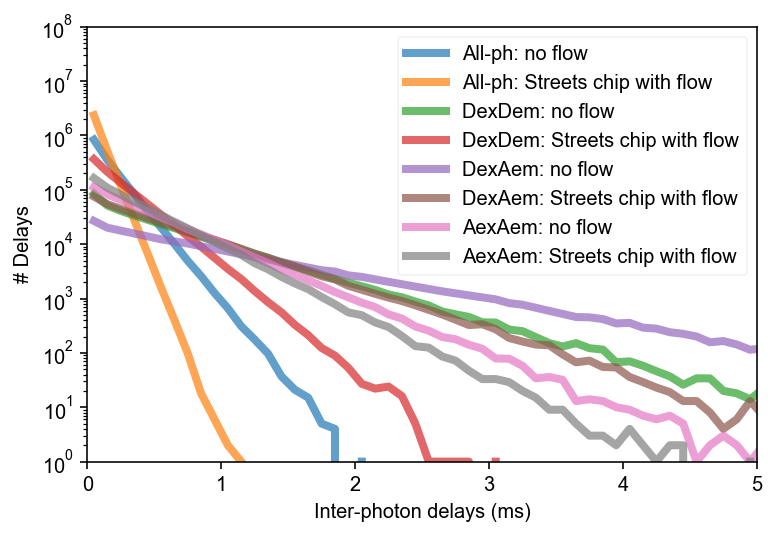

In [28]:
hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(legend_list, loc='best', framealpha=0.2);

## Plot background rates

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

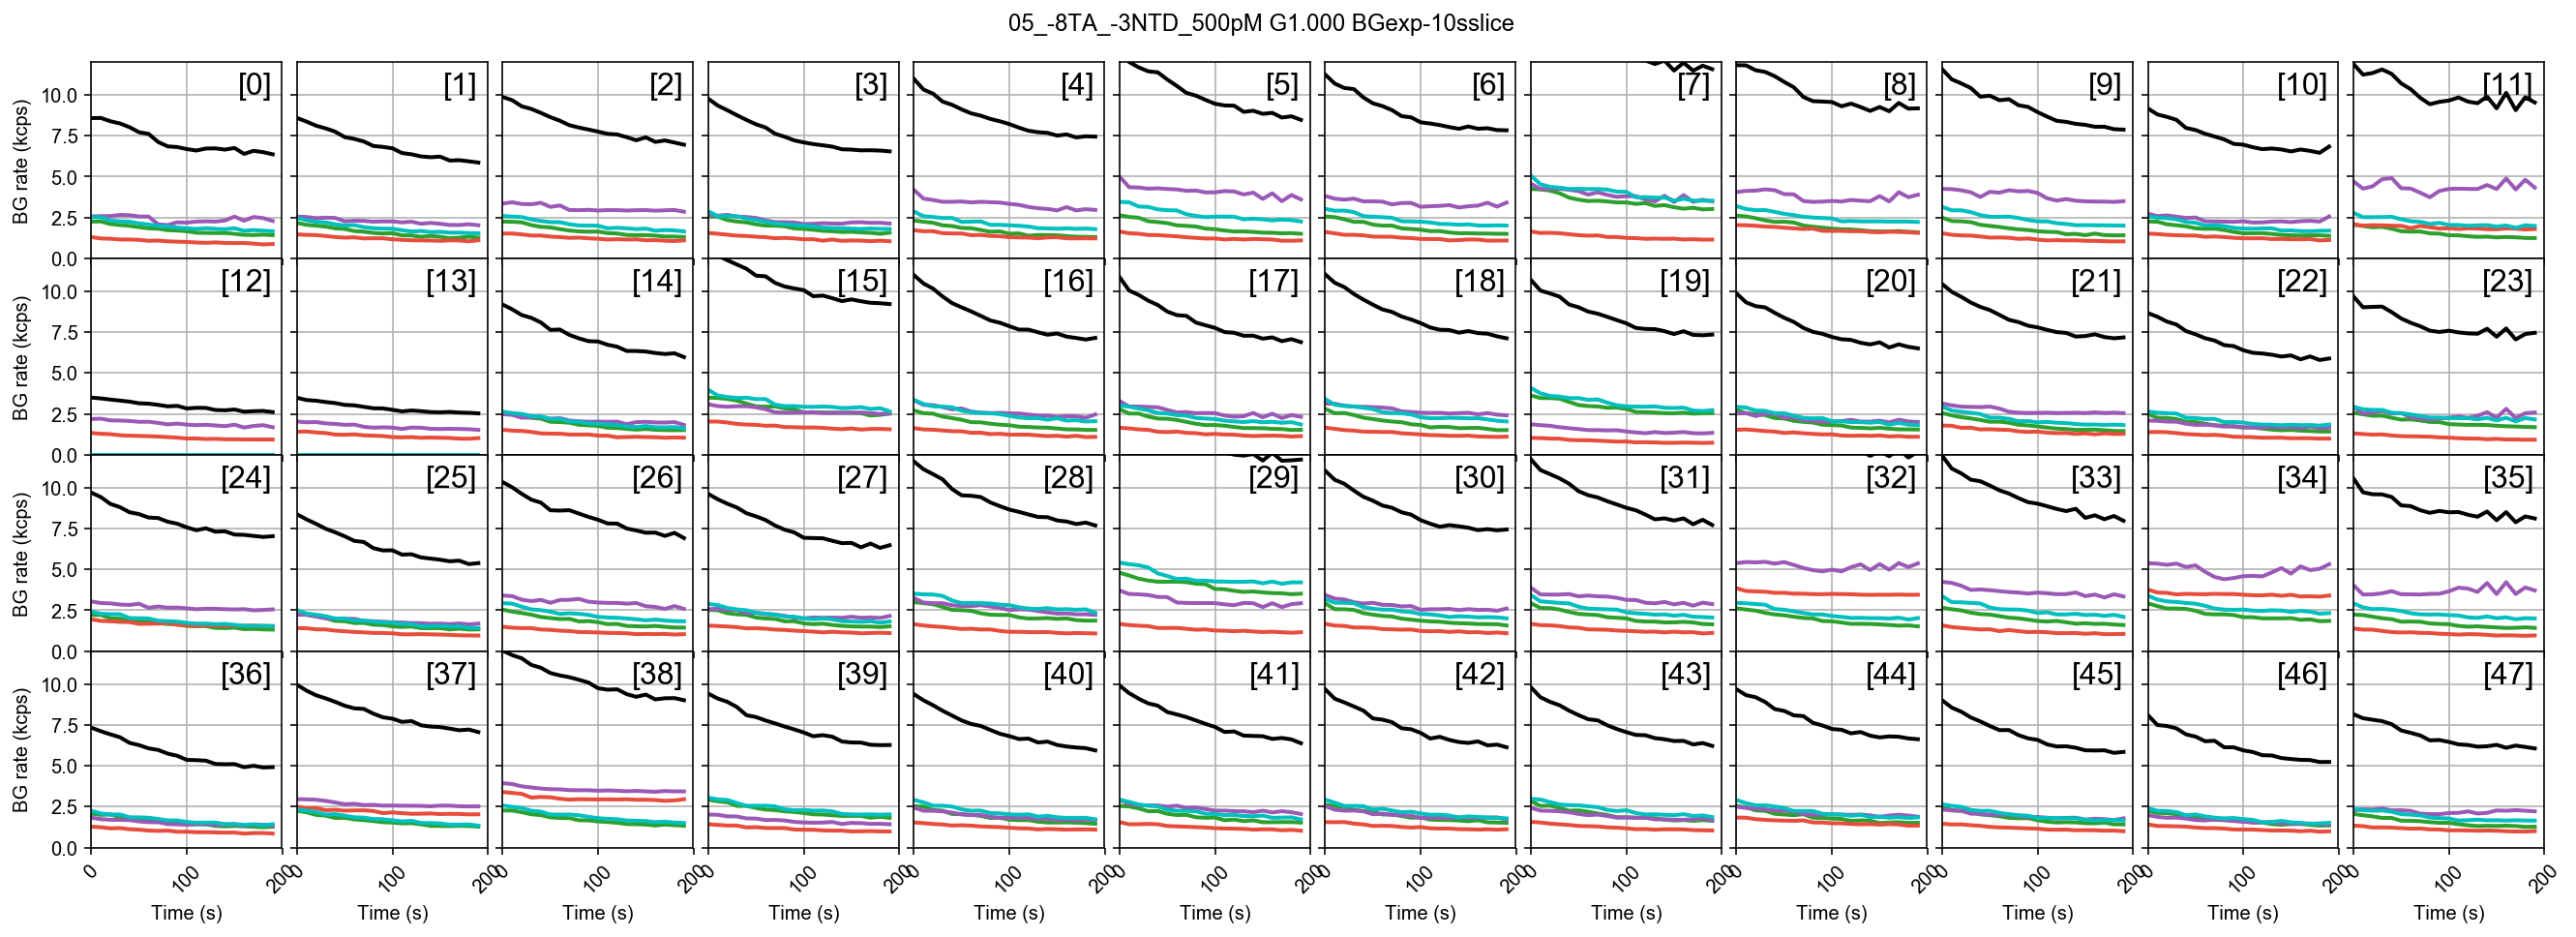

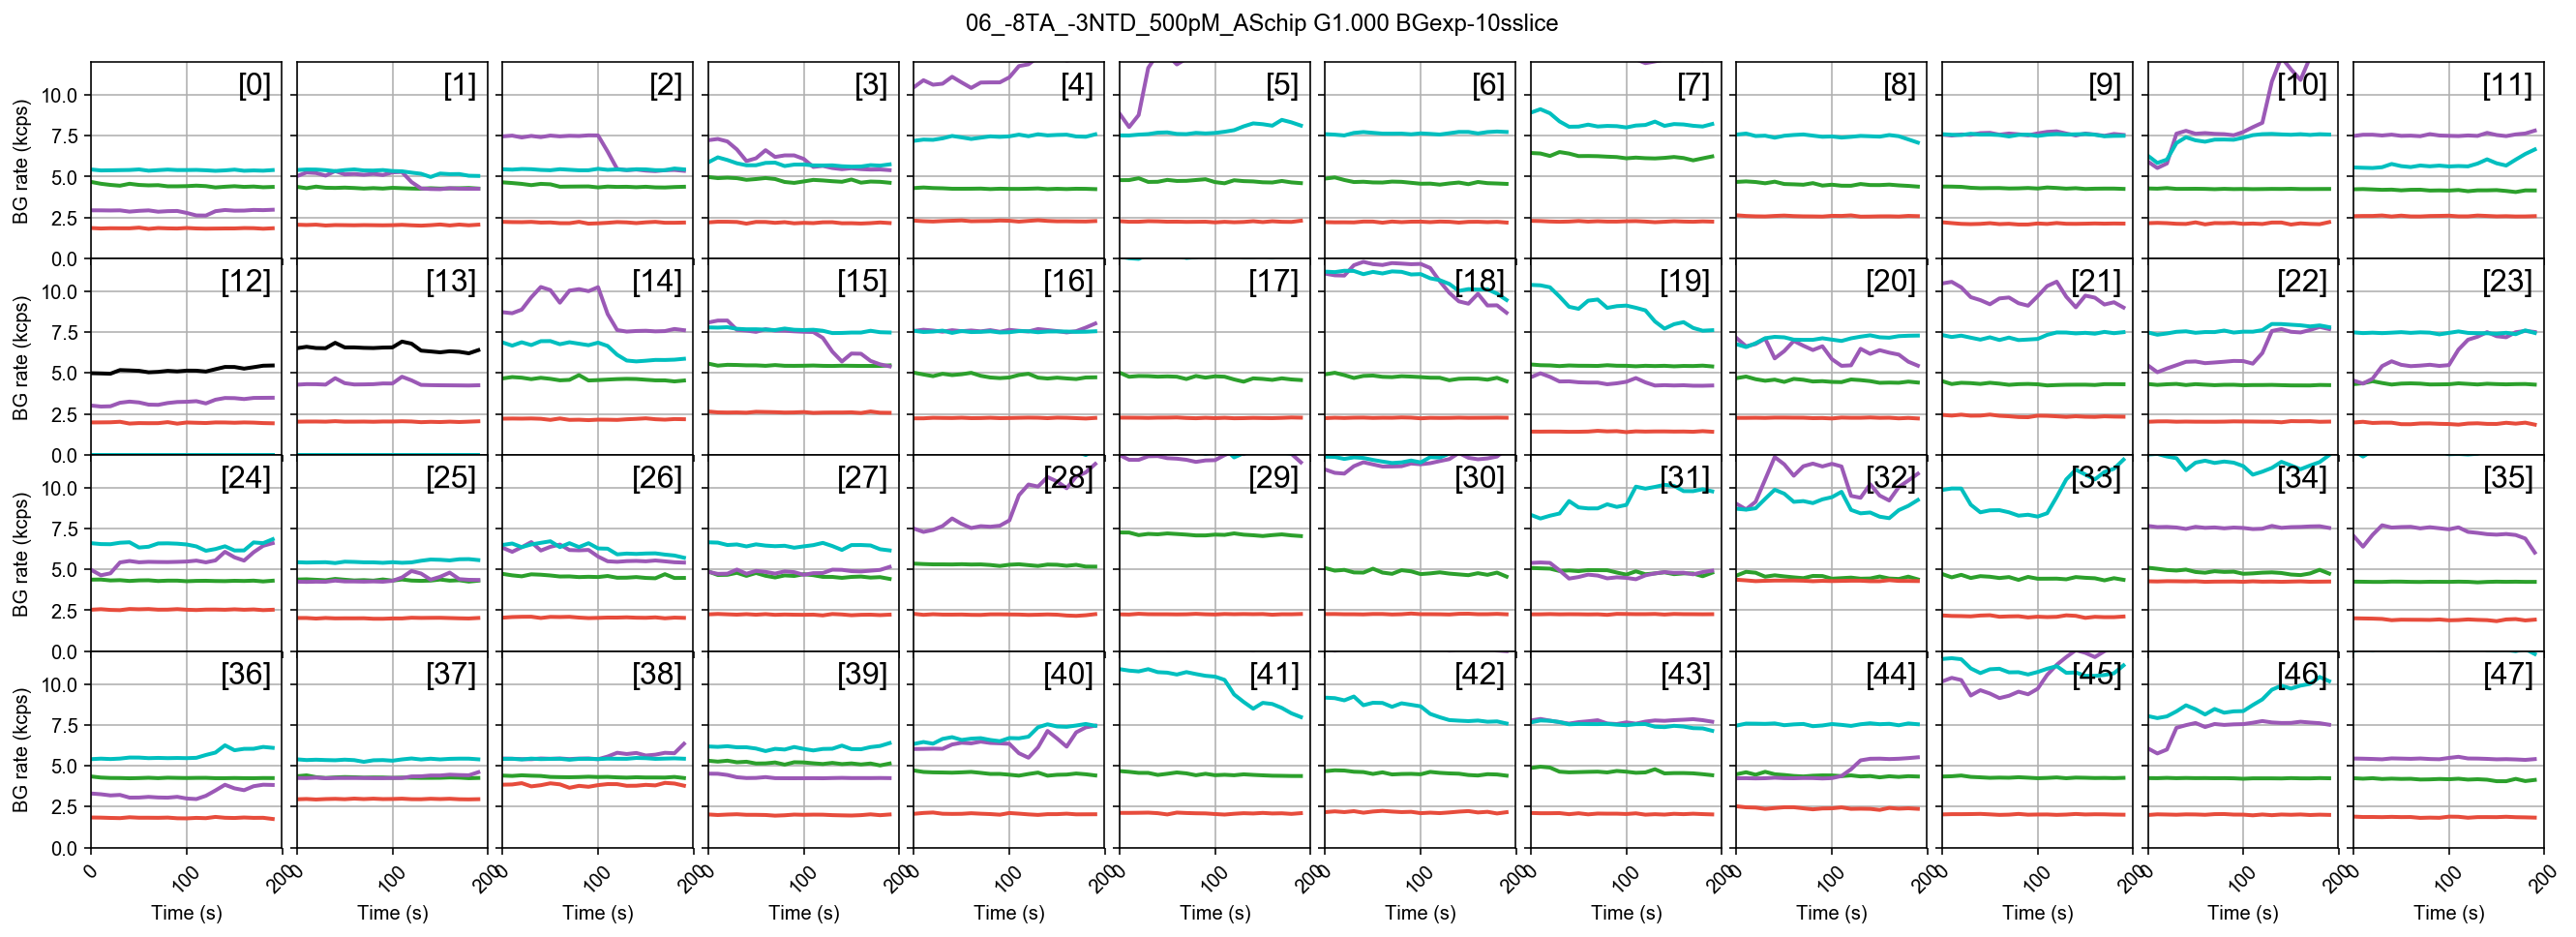

In [29]:
ax = dplot(d0, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12)

ax = dplot(d1, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12);

In [30]:
bg_AexDem_0 = d0.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_0 = d0.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_0 = d0.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_0 = d0.bg_from(Ph_sel(Dex='Aem'))

bg_AexDem_1 = d1.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_1 = d1.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_1 = d1.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_1 = d1.bg_from(Ph_sel(Dex='Aem'))

In [31]:
import matplotlib.patches as mpatches

In [32]:
green_patch = mpatches.Patch(color=green, label='no flow')
red_patch = mpatches.Patch(color=red, label='no flow')
blue_patch = mpatches.Patch(color=blue, label='flow rate = 10μL/hr')
purple_patch = mpatches.Patch(color=purple, label='flow rate = 10μL/hr')

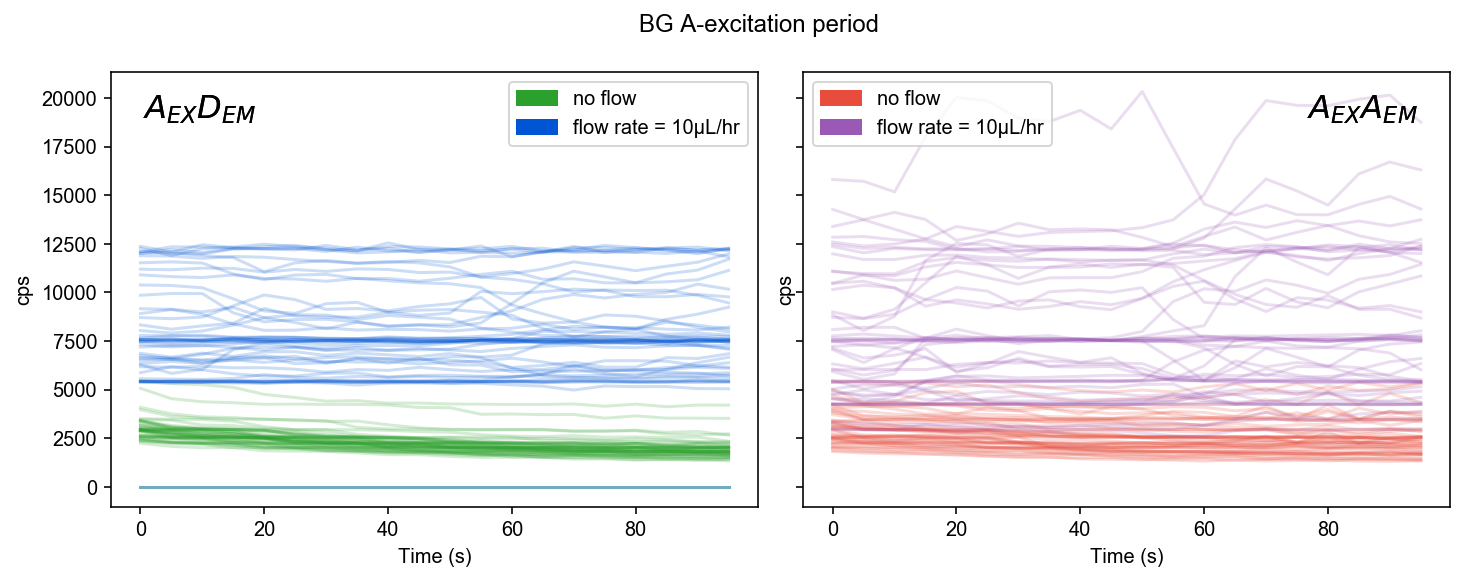

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG A-excitation period")
t0 = np.arange(len(bg_AexDem_0[0])) * 5
t1 = np.arange(len(bg_AexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_AexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_AexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_AexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_AexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left');

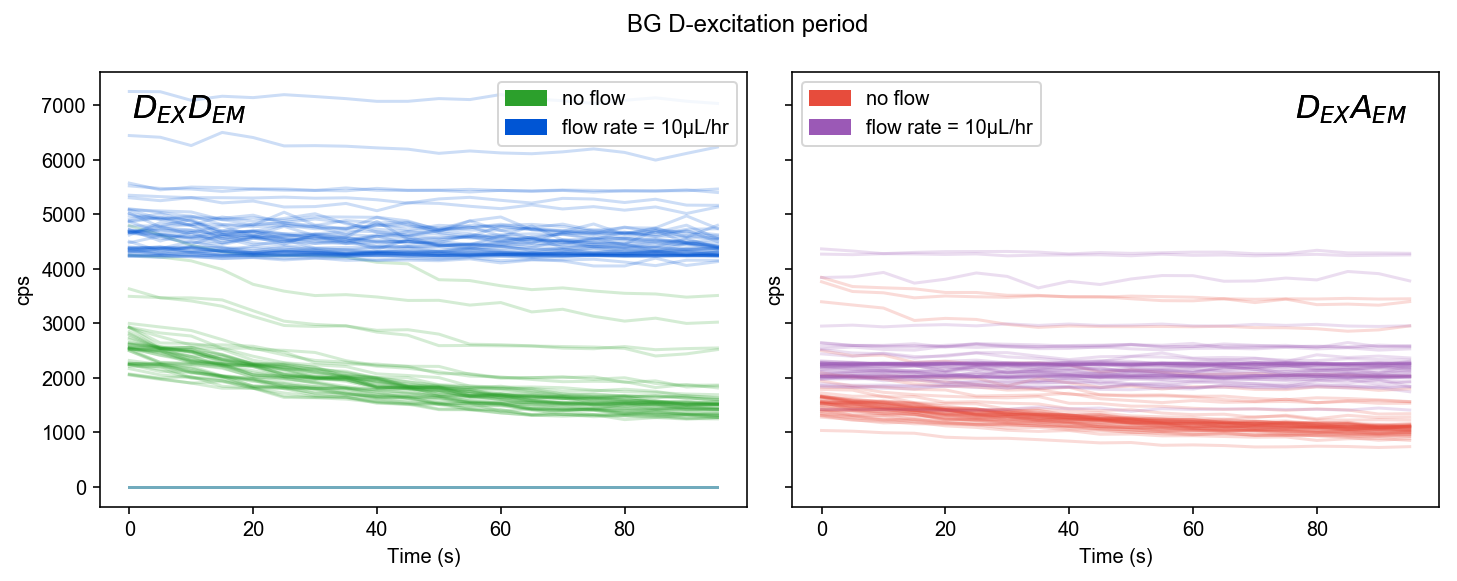

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG D-excitation period")
t0 = np.arange(len(bg_DexDem_0[0])) * 5
t1 = np.arange(len(bg_DexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_DexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_DexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_DexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_DexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left');

# Burst search

## Burst search with constant threshold

In [35]:
Dex0 = d0.setup['excitation_input_powers'][0] * 1e3
Dex1 = d1.setup['excitation_input_powers'][0] * 1e3
Aex0 = d0.setup['excitation_input_powers'][1] * 1e3
Aex1 = d1.setup['excitation_input_powers'][1] * 1e3
power0 = f'D{Dex0:.0f}mW_A{Aex0:.0f}mW'
power1 = f'D{Dex1:.0f}mW_A{Aex1:.0f}mW'
power0, power1 

('D300mW_A600mW', 'D500mW_A800mW')

In [36]:
Dex_ratio = 300 / 500 # [mW]
Aex_ratio = 600 / 800 # [mW]
Dex_ratio, Aex_ratio

(0.6, 0.75)

In [37]:
cps_ratio = np.mean((50e3 / Dex_ratio, 50e3 / Aex_ratio))
cps_ratio

75000.0

**define 3 burst searches**
1. constant threshold for sample with no chip and no flow (compared to a threshold scaled by `power_ratio`)
2. constant threshold for sample with Streets chip and flow
3. moving threshold - compare both samples 

In [38]:
bsearch_params_constant0 = dict(m=10, ph_sel=Ph_sel('all'), pax=True, min_rate_cps=50_000)
bsearch_params_constant1 = dict(m=10, ph_sel=Ph_sel('all'), pax=True, min_rate_cps=75_000)
bsearch_params_moving = dict(m=10, ph_sel=Ph_sel('all'), pax=True, F=6)

In [39]:
d2 = d1.copy()
d3 = d1.copy()

Deep copy executed.
Deep copy executed.


In [40]:
d0.burst_search(**bsearch_params_constant0)
d1.burst_search(**bsearch_params_constant1)
d2.burst_search(**bsearch_params_moving)
d3.burst_search(**bsearch_params_moving)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [41]:
d0.calc_max_rate(m=bsearch_params_constant0['m'])
d1.calc_max_rate(m=bsearch_params_constant1['m'])
d2.calc_max_rate(m=bsearch_params_moving['m'])
d3.calc_max_rate(m=bsearch_params_moving['m'])

In [42]:
size_th = 20
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='DAem'),
                    na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

# Burst selection

In [43]:
size_th = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
ds0 = d0.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds0.nd, ds0.na, ds0.naa)]
ds0.add(Su=Su)
Su2 = [(nd + nda + na)/(nd + nda + na + naa) 
       for nd, na, nda, naa in zip(ds0.nd, ds0.na, ds0.nda, ds0.naa)]
ds0.add(Su2=Su2)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

In [44]:
size_th = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
ds1 = d1.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds1.nd, ds1.na, ds1.naa)]
ds1.add(Su=Su)
Su2 = [(nd + nda + na)/(nd + nda + na + naa) 
       for nd, na, nda, naa in zip(ds1.nd, ds1.na, ds1.nda, ds1.naa)]
ds1.add(Su2=Su2)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

# Collapse

Pooling data from all 48 spots

In [45]:
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=1,
                   na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

<IPython.core.display.Math object>

In [46]:
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

Two size selections for isolation of the FRET population using ACBS.

In [47]:
ds0_th1 = ds0.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
ds0_th2 = ds0_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs0_th = ds0_th2.collapse(update_gamma=False)

ds1_th1 = ds1.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
ds1_th2 = ds1_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs1_th = ds1_th2.collapse(update_gamma=False)

# Save burst search results to CSV

Burst search results are loaded into a DataFrame and saved as .CSV

In [48]:
Path('results/').mkdir(exist_ok=True)

## Save 48-spot burst results

In [49]:
fname_bursts_50kcps = f'results/{f0}_bsearch_params'
for k, v in bsearch_params_constant0.items():
    fname_bursts_50kcps += f'_{k}_{v}'
fname_bursts_50kcps

'results/05_-8TA_-3NTD_500pM_bsearch_params_m_10_ph_sel_all_pax_True_min_rate_cps_50000'

In [50]:
fname_bursts_75kcps = f'results/{f1}_bsearch_params'
for k, v in bsearch_params_constant1.items():
    fname_bursts_75kcps += f'_{k}_{v}'
fname_bursts_75kcps

'results/06_-8TA_-3NTD_500pM_ASchip_bsearch_params_m_10_ph_sel_all_pax_True_min_rate_cps_75000'

In [51]:
fname_bursts_F6_0 = f'results/{f0}_bsearch_params'
for k, v in bsearch_params_moving.items():
    fname_bursts_F6_0 += f'_{k}_{v}'
fname_bursts_F6_0

'results/05_-8TA_-3NTD_500pM_bsearch_params_m_10_ph_sel_all_pax_True_F_6'

In [52]:
fname_bursts_F6_1 = f'results/{f1}_bsearch_params'
for k, v in bsearch_params_moving.items():
    fname_bursts_F6_1 += f'_{k}_{v}'
fname_bursts_F6_1

'results/06_-8TA_-3NTD_500pM_ASchip_bsearch_params_m_10_ph_sel_all_pax_True_F_6'

In [53]:
fname_bsearch_data0 = f'results/{f0}_burst_data'
fname_bsearch_data1 = f'results/{f1}_burst_data'
fname_bsearch_data0, fname_bsearch_data1

('results/05_-8TA_-3NTD_500pM_burst_data',
 'results/06_-8TA_-3NTD_500pM_ASchip_burst_data')

In [54]:
bsearch_data0 = bext.burst_data(d0, include_bg=False)
bsearch_data1 = bext.burst_data(d1, include_bg=False)

In [55]:
bsearch_data0.to_csv(fname_bsearch_data0 + '.csv')
bsearch_data1.to_csv(fname_bsearch_data1 + '.csv')

In [56]:
pd.read_csv(fname_bsearch_data0 + '.csv', index_col=0).head()

size_raw   t_start    t_stop  width_ms         E         S         nd  \
0        10  0.111762  0.111955  0.192625 -0.109697  0.378698   0.566183   
1        33  0.220837  0.221162  0.325062  0.163064  1.098282  15.267917   
2        13  0.231640  0.231863  0.222663 -0.051113  1.052553   9.498535   
3        13  0.231704  0.231950  0.246125 -0.069871  0.731326   7.445694   
4        11  0.235145  0.235333  0.187812  0.365185  1.052354   3.577022   

         na         nt        nda       naa       max_rate       nar  spot  
0 -0.251053   8.331979   4.513142  3.503707   32956.463262 -0.251053     0  
1  2.576337  30.185147  11.178408  1.162485  174177.702928  2.576337     0  
2 -0.290202  11.071872   2.437223 -0.573684   58489.854491 -0.290202     0  
3 -0.320781  10.868700   2.377922  1.365865   45575.087493 -0.320781     0  
4  1.755219   9.373653   2.525306  1.516106   39125.668436  1.755219     0

In [57]:
pd.read_csv(fname_bsearch_data1 + '.csv', index_col=0).head()

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


size_raw   t_start    t_stop  width_ms         E         S         nd  \
0        11  0.107461  0.107582  0.120512  0.166283  1.028721   3.436848   
1        10  0.107743  0.107872  0.128387  0.428293  1.034932   2.400048   
2        10  0.107810  0.107928  0.118563  0.245139  0.629519   1.445960   
3        42  0.108156  0.108523  0.366663  0.119114  1.140394  20.286595   
4        11  0.139401  0.139531  0.129163  0.381998  1.031258   3.396427   

         na         nt        nda       naa       max_rate       nar  spot  
0  0.776056   9.203870   4.345210  0.645757   52532.416089  0.776056     0  
1  1.761422   8.086501   2.302422  1.622608   47524.960464  1.761422     0  
2  0.779679   8.232933   3.355805  2.651489   52688.558840  0.779679     0  
3  2.318644  36.535228  14.007784 -0.077795  213377.591246  2.318644     0  
4  1.759982   9.074950   2.298211  1.620330   51658.781100  1.759982     0